In [2]:
from tools import datacleaner as dtclean
from tools import dataexplore as dtexp
from view import data_visualization as dtview
import pandas as pd
import numpy as np
from fbprophet import Prophet
from evaluation import forecast_metrics as fm
import seaborn as sns
import plotly.graph_objs as go
import plotly.tools
import matplotlib.pyplot as plt
# Offline mode
import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot
import warnings

warnings.filterwarnings('ignore')
# "high resolution"
%config InlineBackend.figure_format = 'retina'
init_notebook_mode(connected=True)

# Obtendo o dataframe

In [3]:
df_274_time_sale = dtclean.get_Dataframes_time(274,'s')
df_274_time_sale.reset_index(inplace=True)
df_274_sale = dtclean.get_Dataframes(274,'s')
df_274_sale.reset_index(inplace=True)

sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})


In [4]:
iplot(dtview.plot_scatter(df_274_time_sale,title='Produtos vendidos'))

<div class="alert alert-block alert-info">
<b>Obs:</b> Notamos nesse gráfico que há um pico de vendas de produtos no mês de março e uma queda significativa no fim
do mês de maio. Na celula abaixo criamos um modelo sem promover afinamentos para efeitos de comparação.
</div>

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


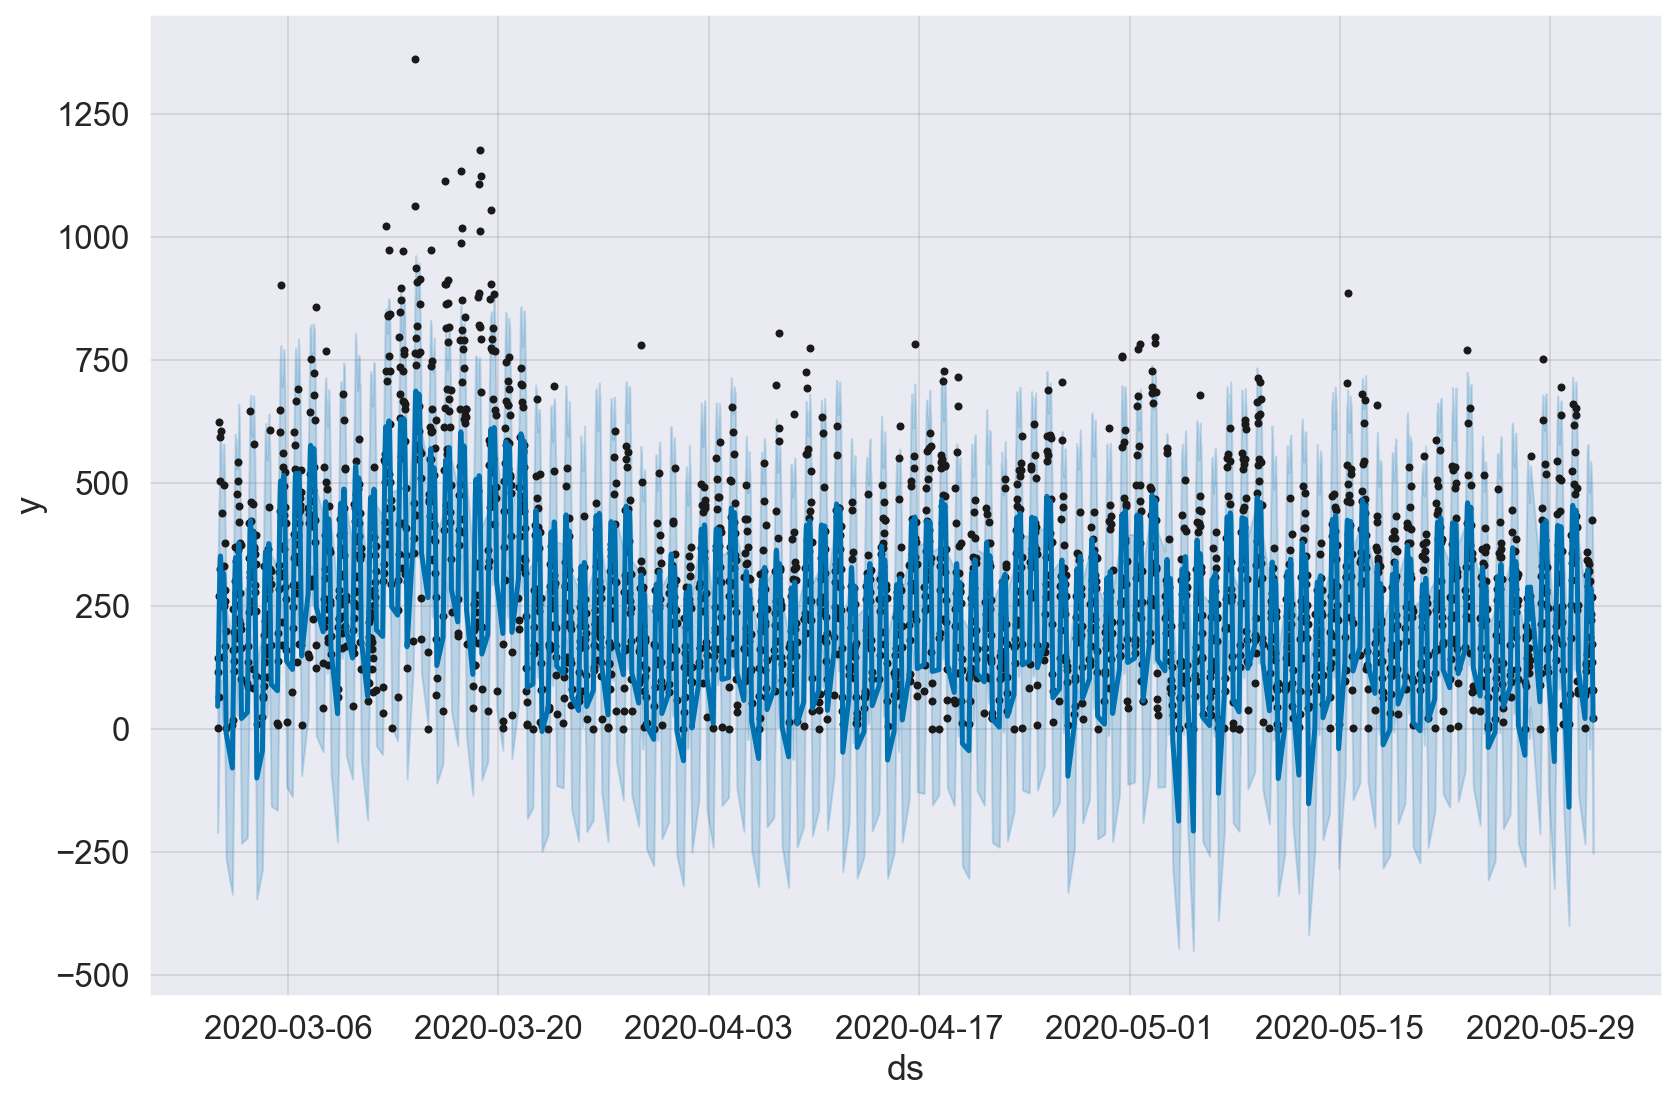

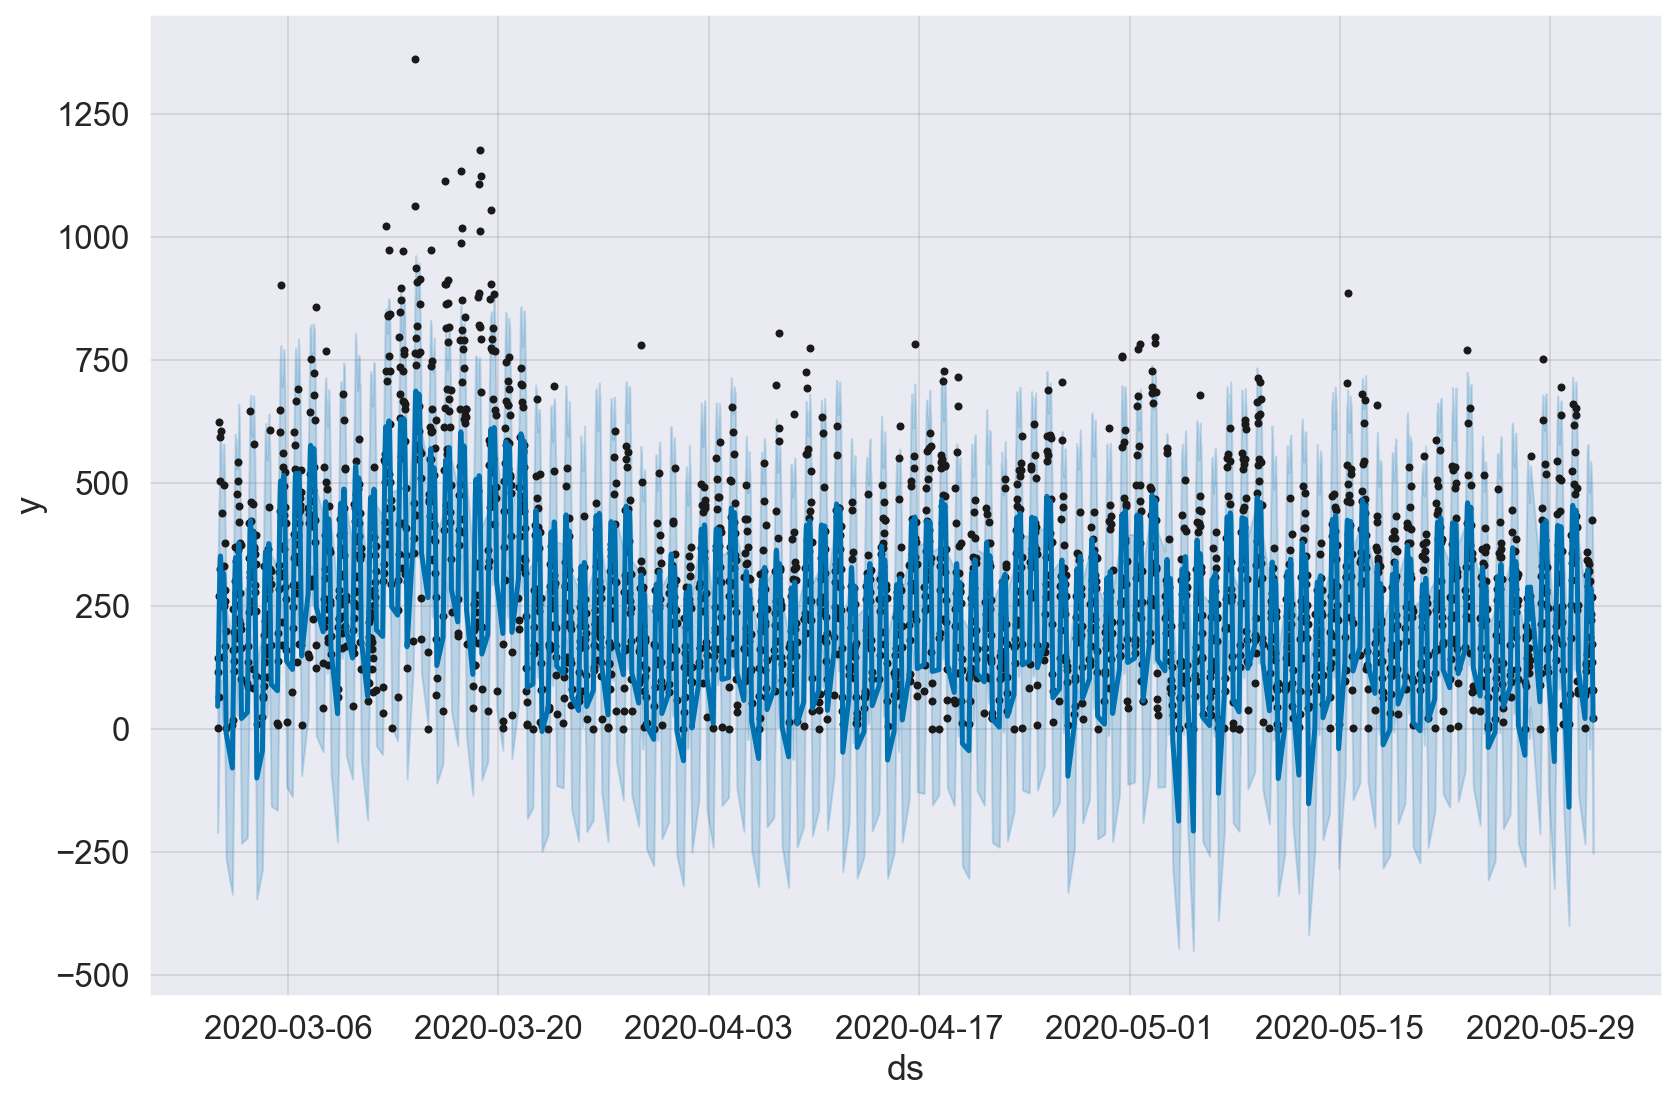

In [6]:
model = Prophet(interval_width=0.95)
model.fit(df_274_time_sale)
forecast = model.predict(df_274_time_sale)
model.plot(forecast, figsize=(12,8))


# Análise dos Dados

<div class="alert alert-block alert-warning">
<b>Obs:</b> Na análise dos dados identificamos incosistências que podem comprometer a performance dos modelos
gerados nesse trabalho. Para mitigar esse impacto foram feitas análises sobre os dados agregados ao dia e por hora.
Esse notebook inicia a apresentação dos dados agregados por hora.
</div>

In [7]:
iplot(dtview.plot_scatter(df_274_time_sale,title='Vendas/hora (março-maio de 2020)'))

In [8]:
df_new = dtexp.date_features(df_274_time_sale)
mesAgregado = pd.DataFrame(df_new.groupby("semana")["y"].sum()).reset_index().sort_values('y')
semanaAgregada = pd.DataFrame(df_new.groupby("num")["y"].sum()).reset_index().sort_values('num')
iplot(dtview.plot_dados_agregados_semana_mes(mesAgregado,tipo_agregacao='m',xaxes_title='Nº da semana',yaxis_title='Total de produtos vendidos',
                                      title='Vendas por Semana', hover='31/05'))
iplot(dtview.plot_dados_agregados_semana_mes(semanaAgregada,xaxes_title='Nº do dia (0 = Domingo, 1 = Segunda ...)',yaxis_title='Total de produtos vendidos',
                                      title='Vendas por dia'))

<div class="alert alert-block alert-info">
<b>Vendas por Semana:</b> Mensalmente há, conforme já observado, um pico de produtos vendidos entre a 9ª e a 11ª semana de 2020,
que corresponde ao período de 24de fevereiro à 15 de março, contudo nossos dados começam em 01 de março.
Destaca-se a última semana (22ª) como a de menor volume de produtos vendidos.
<p><b>Vendas por Dia:</b> No volume de vendas diárias nota-se que a quarta-feira é o dia de menor volume de vendas, e,
a partir da quinta-feira há um salto no volume de vendas com o pico ocorrendo no sábado.</p>
</div>

In [9]:
df_274_sale_treino, df_274_sale_teste = dtexp.configura_dataframe_treino_teste(df_274_time_sale)
periods=df_274_sale_teste.shape[0]

# Visualizando o montante de dados para os datasets de treino e de teste

In [10]:
iplot(dtview.compare_dataframes_with_scatter(df_274_sale_treino,
                                   df_274_sale_teste,
                                   title='Montante de dados de vendas de Treinamento e Teste',
                                    mode='lines',
                                   name1='Treinamento',
                                   name2='Teste'))

In [11]:
prophet = Prophet()
prophet.fit(df_274_sale_treino)
future_vendas = prophet.make_future_dataframe(periods=periods, freq='30min')
# Removendo valores fora do range de atendimento da loja (22:30 - 05:59)
future_vendas['ds'] = pd.to_datetime(future_vendas['ds'])
future_vendas = future_vendas.set_index(pd.DatetimeIndex(future_vendas['ds']))
future_vendas = future_vendas.between_time('10:00','16:00')
forecast_vendas = prophet.predict(future_vendas)
forecast_vendas = dtclean.remove_negative_values(forecast_vendas)
iplot(dtview.plot_forecast_as_table(forecast_vendas))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


# Visualizando os componentes da série temporal

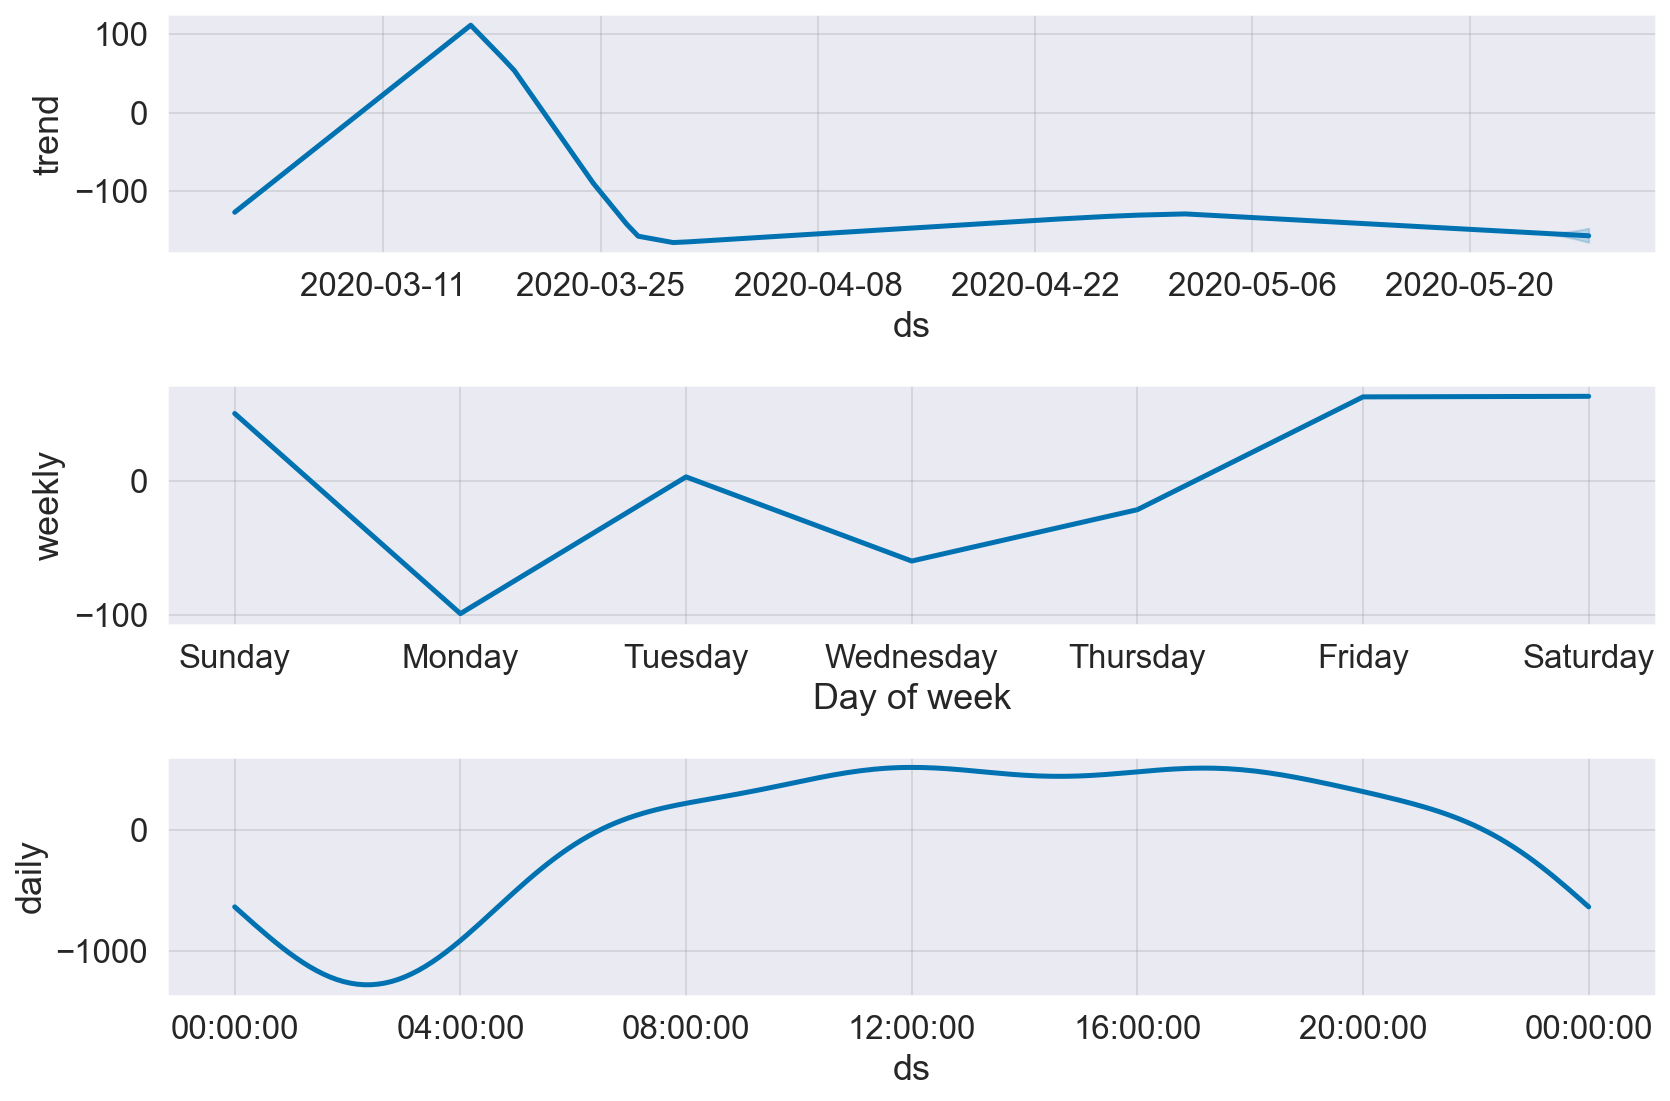

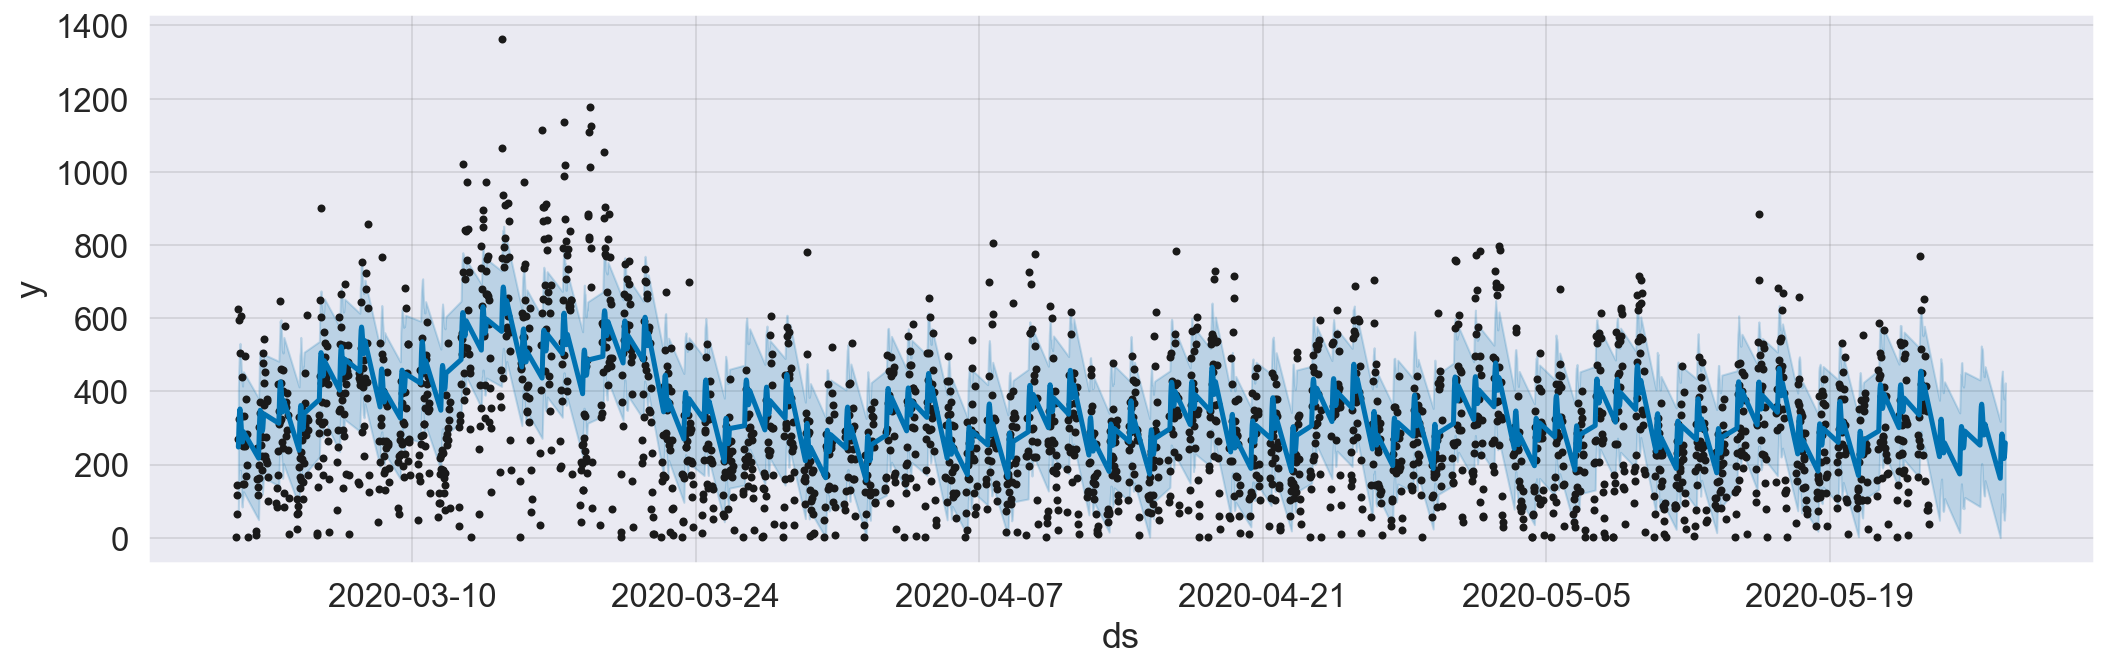

In [12]:
fig = prophet.plot_components(forecast_vendas, figsize=(12,8))

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = prophet.plot(forecast_vendas,ax=ax)
plt.show()

In [16]:
df_274_sale_teste_forecast = prophet.predict(df_274_sale_teste)
df_274_sale_teste_forecast
df_274_sale_teste_forecast=dtclean.remove_negative_values(df_274_sale_teste_forecast)

ds       trend  yhat_lower  yhat_upper  trend_lower  \
0   2020-05-23 21:00:00 -152.435831  -48.774249  289.956083  -152.435831   
1   2020-05-24 08:00:00 -152.926049 -110.528315  221.565861  -152.926049   
2   2020-05-24 08:30:00 -152.948332  -78.152782  263.128846  -152.948332   
3   2020-05-24 09:00:00 -152.970615  -36.147426  301.842198  -152.970615   
4   2020-05-24 09:30:00 -152.992897   10.467455  336.369370  -152.992897   
..                  ...         ...         ...         ...          ...   
207 2020-05-31 18:30:00 -160.880961   44.807031  388.769410  -194.754727   
208 2020-05-31 19:00:00 -160.903244   12.242078  353.281194  -194.881609   
209 2020-05-31 19:30:00 -160.925527  -54.628612  298.524412  -195.020528   
210 2020-05-31 20:00:00 -160.947809 -112.757549  235.506044  -195.172758   
211 2020-05-31 20:30:00 -160.970092 -158.101935  196.480815  -195.308644   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0    -152.435831      271.279569            271.279569            271.279569   
1    -152.926049      212.600572            212.600572            212.600572   
2    -152.948332      250.339996            250.339996            250.339996   
3    -152.970615      288.217609            288.217609            288.217609   
4    -152.992897      329.889607            329.889607            329.889607   
..           ...             ...                   ...                   ...   
207  -127.004065      378.097387            378.097387            378.097387   
208  -126.896984      333.652250            333.652250            333.652250   
209  -126.789904      283.022902            283.022902            283.022902   
210  -126.682823      229.343441            229.343441            229.343441   
211  -126.575742      172.864962            172.864962            172.864962   

          daily  daily_lower  daily_upper     weekly  weekly_lower  \
0    203.928343   203.928343   203.928343  67.351226     67.351226   
1    223.028287   223.028287   223.028287 -10.427715    -10.427715   
2    264.923996   264.923996   264.923996 -14.584000    -14.584000   
3    306.947894   306.947894   306.947894 -18.730285    -18.730285   
4    352.747340   352.747340   352.747340 -22.857733    -22.857733   
..          ...          ...          ...        ...           ...   
207  462.412641   462.412641   462.412641 -84.315254    -84.315254   
208  420.195282   420.195282   420.195282 -86.543032    -86.543032   
209  371.628827   371.628827   371.628827 -88.605925    -88.605925   
210  319.843303   319.843303   319.843303 -90.499862    -90.499862   
211  265.086171   265.086171   265.086171 -92.221209    -92.221209   

     weekly_upper  multiplicative_terms  multiplicative_terms_lower  \
0       67.351226                   0.0                         0.0   
1      -10.427715                   0.0                         0.0   
2      -14.584000                   0.0                         0.0   
3      -18.730285                   0.0                         0.0   
4      -22.857733                   0.0                         0.0   
..            ...                   ...                         ...   
207    -84.315254                   0.0                         0.0   
208    -86.543032                   0.0                         0.0   
209    -88.605925                   0.0                         0.0   
210    -90.499862                   0.0                         0.0   
211    -92.221209                   0.0                         0.0   

     multiplicative_terms_upper        yhat  
0                           0.0  118.843738  
1                           0.0   59.674523  
2                           0.0   97.391664  
3                           0.0  135.246994  
4                           0.0  176.896710  
..                          ...         ...  
207                         0.0  217.216426  
208                         0.0  172.749006  
209                         0.0  122.09

# Visualizando a previsão

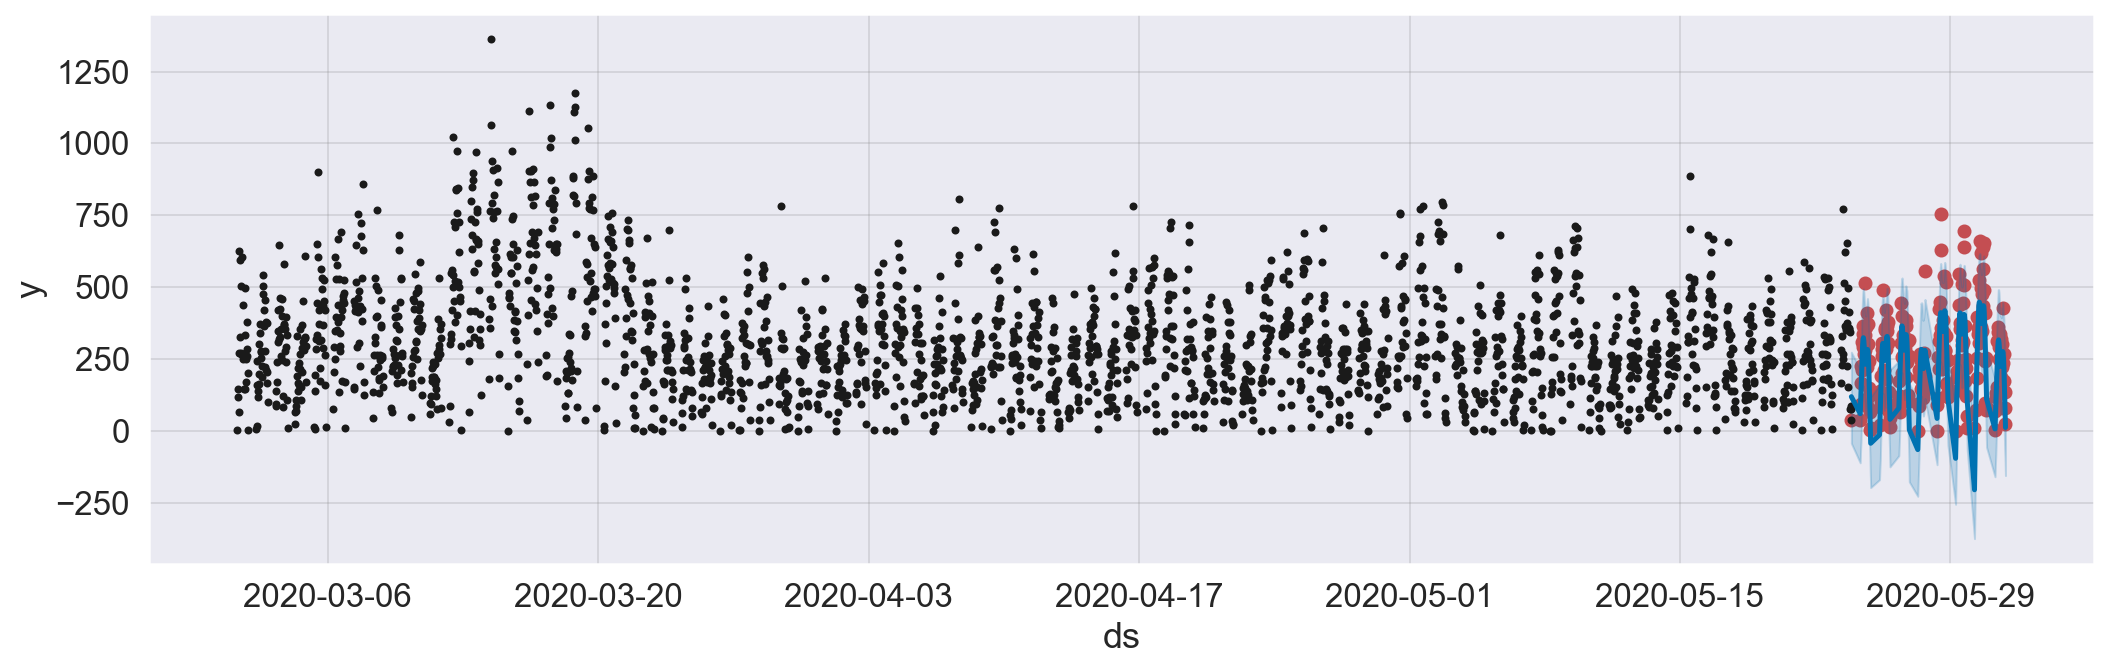

In [14]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_274_sale_teste.ds,df_274_sale_teste['y'], color='r')
fig = prophet.plot(df_274_sale_teste_forecast,ax=ax)
plt.show()


# Comparação entre as vendas previstas e realizadas

In [15]:
iplot(dtview.compare_dataframes_with_scatter(df_274_sale_teste,
                                   df_274_sale_teste_forecast,
                                   title='Previsão de vendas vs Vendas originais realizadas',
                                    mode='lines',
                                   name1='Teste',
                                   name2='Previsto',
                                  is_forecast=True))

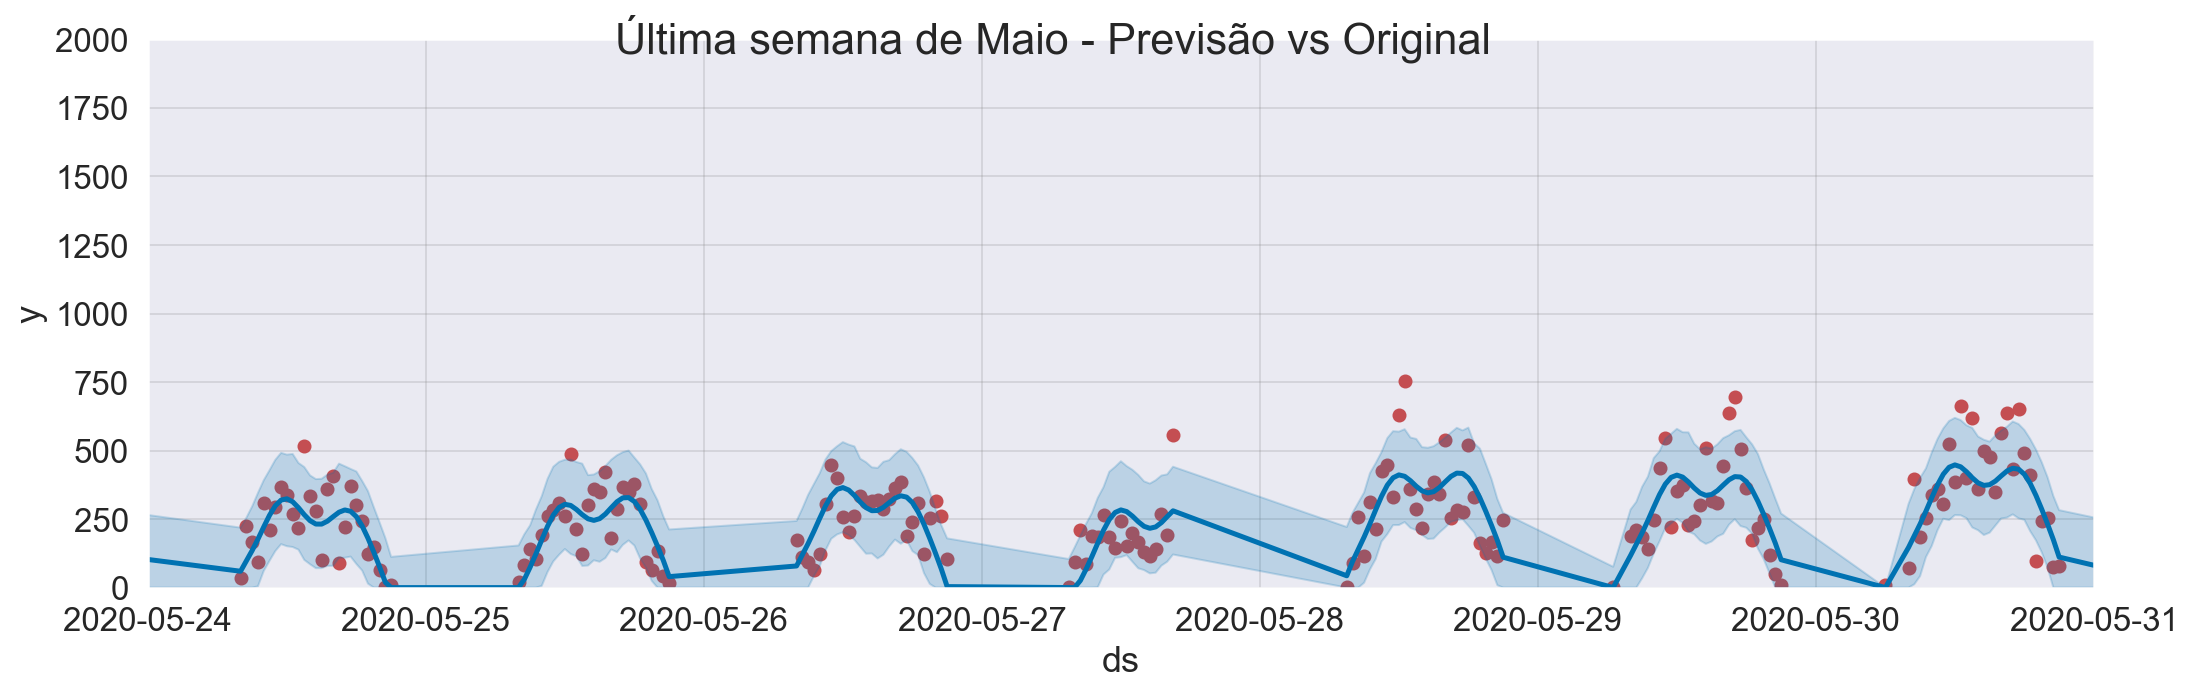

In [14]:
# Visualizando a previsão e os dados originais
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_274_sale_teste.ds, df_274_sale_teste['y'], color='r')
fig = prophet.plot(df_274_sale_teste_forecast, ax=ax)
ax.set_xbound(lower='2020-05-24', upper='2020-05-31')
ax.set_ylim(0, 2000)
plot = plt.suptitle('Última semana de Maio - Previsão vs Original')

In [15]:
print("MAPE ------> {}".format(fm.mape(np.array(df_274_sale_teste['y']),
                                                    np.array(df_274_sale_teste_forecast['yhat']))))


MAPE ------> 0.7240836968973005


In [16]:
iplot(dtview.compare_dataframes_with_bar(
    df_274_sale_teste,
    df_274_sale_teste_forecast,
    nametrace1='Valor Real',
    nametrace2='Valor Previsto',
    idx_end=28))

# Filtrando o horário de atendimento

In [ ]:
df_t_new = df_274_sale_teste.copy()
df_t_new['ds'] = pd.to_datetime(df_t_new['ds'])
df_t_new = df_t_new.set_index(pd.DatetimeIndex(df_t_new['ds']))
df_t_new = df_t_new.between_time('10:00','16:00')
df_274_sale_teste_forecast = prophet.predict(df_t_new)
df_274_sale_teste_forecast=dtclean.remove_negative_values(df_274_sale_teste_forecast)


# Visualizando a previsão

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_t_new.ds,df_t_new['y'], color='r')
fig = prophet.plot(df_274_sale_teste_forecast,ax=ax)
plt.show()


# Comparação entre as vendas previstas e realizadas

In [ ]:
iplot(dtview.compare_dataframes_with_scatter(df_t_new,
                                   df_274_sale_teste_forecast,
                                   title='Previsão de vendas vs Vendas originais realizadas',
                                    mode='lines',
                                   name1='Teste',
                                   name2='Previsto',
                                  is_forecast=True))

In [ ]:
# Visualizando a previsão e os dados originais
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_t_new.ds, df_t_new['y'], color='r')
fig = prophet.plot(df_274_sale_teste_forecast, ax=ax)
ax.set_xbound(lower='2020-05-24', upper='2020-05-31')
ax.set_ylim(0, 2000)
plot = plt.suptitle('Última semana de Maio - Previsão vs Original')

In [ ]:
print("MAPE ------> {}".format(fm.mape(np.array(df_t_new['y']),
                                                    np.array(df_274_sale_teste_forecast['yhat']))))


In [ ]:
iplot(dtview.compare_dataframes_with_bar(
    df_t_new,
    df_274_sale_teste_forecast,
    nametrace1='Valor Real',
    nametrace2='Valor Previsto',
    idx_end=28))


# Criando novo modelo com os feriados

In [17]:
prophet_feriados = Prophet(holidays=dtclean.get_Holiday())
prophet_feriados.add_country_holidays('BR')
prophet_feriados.fit(df_274_sale_treino)
# Criando as datas futuras previstas pelo prophet
# A frequência especificada em horas (os dados estão em horas)
future_feriados = prophet_feriados.make_future_dataframe(freq='30min', periods=periods)
# Prevendo os valores
forecast_feriados = prophet_feriados.predict(future_feriados)
# Removendo valores fora do range de atendimento da loja (22:30 - 05:59)
future_feriados['ds'] = pd.to_datetime(future_feriados['ds'])
future_feriados = future_feriados.set_index(pd.DatetimeIndex(future_feriados['ds']))
future_feriados = future_feriados.between_time('10:00','16:00')
# Previsão optimizada dos valores
forecast_feriados = prophet_feriados.predict(future_feriados)
forecast_feriados = dtclean.remove_negative_values(forecast_feriados)
iplot(dtview.plot_forecast_as_table(forecast_feriados))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


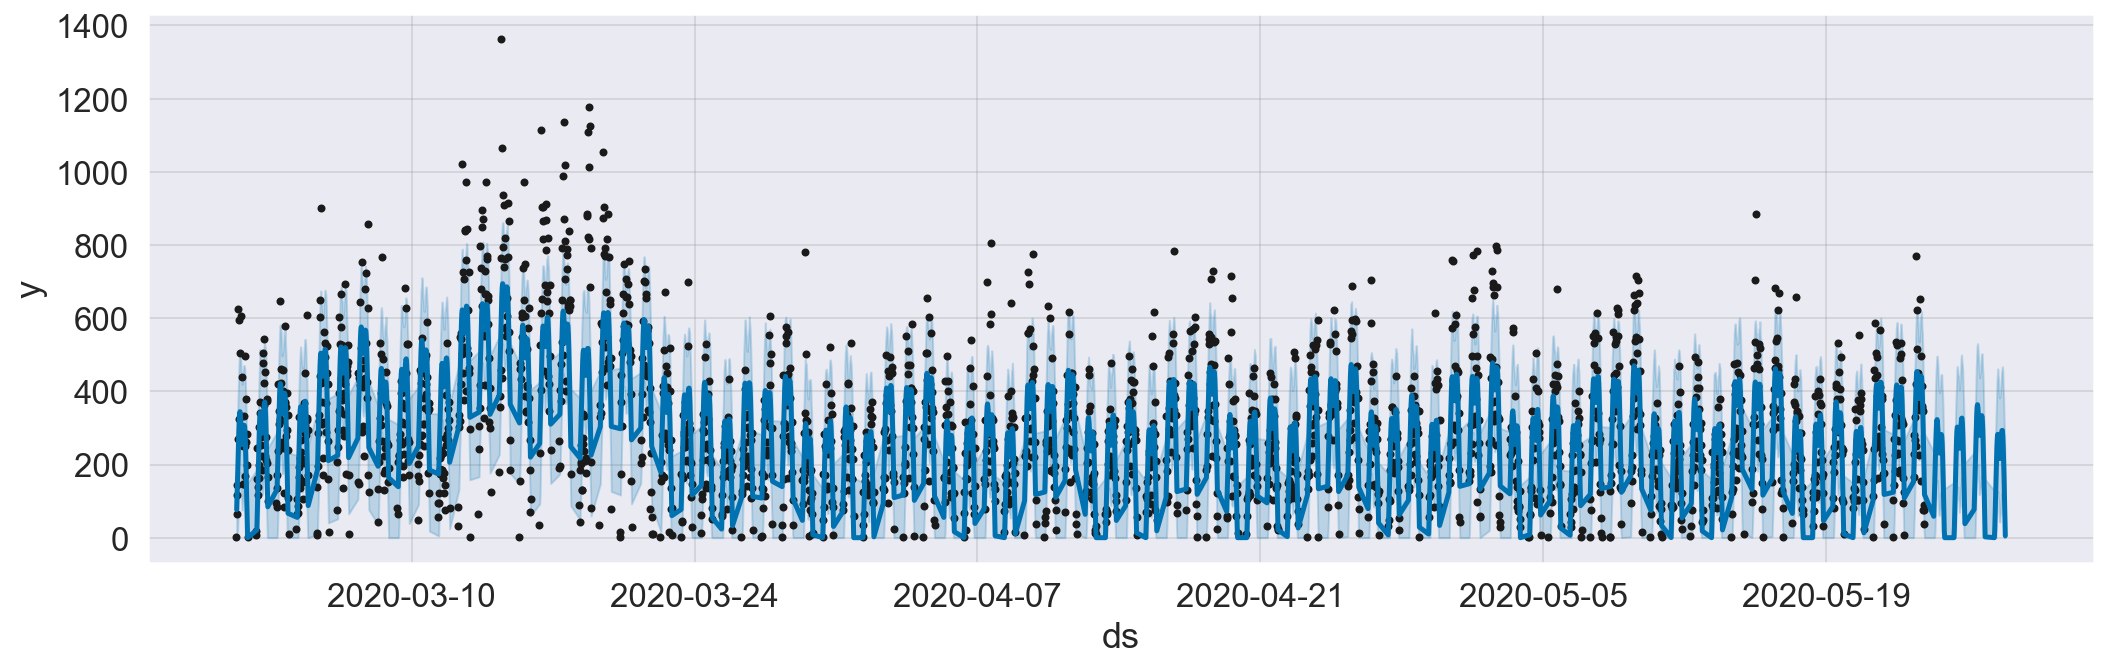

In [18]:
plt,fig_forecast_feriado = dtview.plot_forecast(forecast_feriados,prophet_feriados,f,ax)
plt.show()


## Visualizar dataframe de teste previsto e original com feriados

In [19]:
forecast_teste_feriados = prophet_feriados.predict(df_274_sale_teste)
forecast_teste_feriados = dtclean.remove_negative_values(forecast_teste_feriados)

iplot(dtview.compare_dataframes_with_scatter(
    df_274_sale_teste,
    forecast_teste_feriados,
    title='Dados Previsto vs Original última semana de maio/2020',
    mode='lines',
    name1='Original',
    name2='Previsão com feriados',
    is_forecast=True))

In [20]:
mape_com_feriados = fm.mape(np.array(df_274_sale_teste.y),np.array(forecast_teste_feriados.yhat))
print("MAPE",mape_com_feriados)

MAPE 0.715228333144664


# FIM ANALISE POR HORA

# **Análise dos dados de vendas agupadas ao dia (loja 274)**

In [21]:
# Análise de vendas agrupadas por dia

iplot(dtview.plot_scatter(df_274_sale,title='Produtos vendidos'))


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


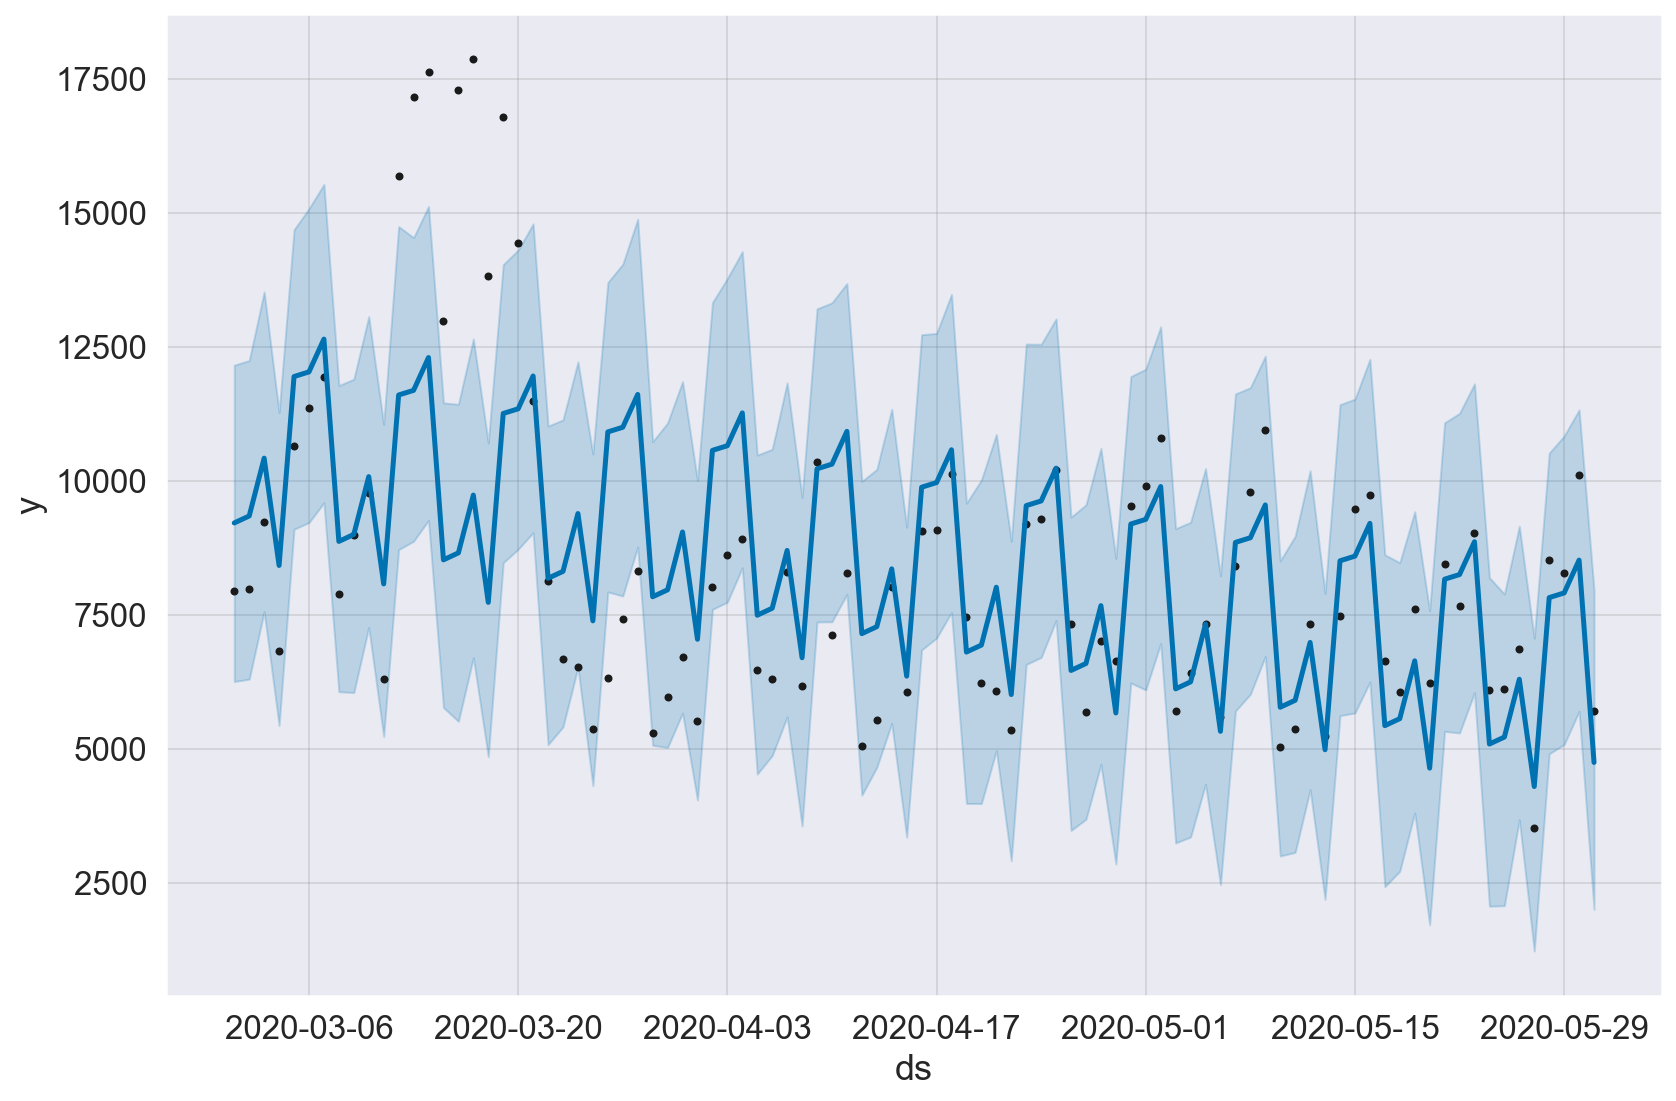

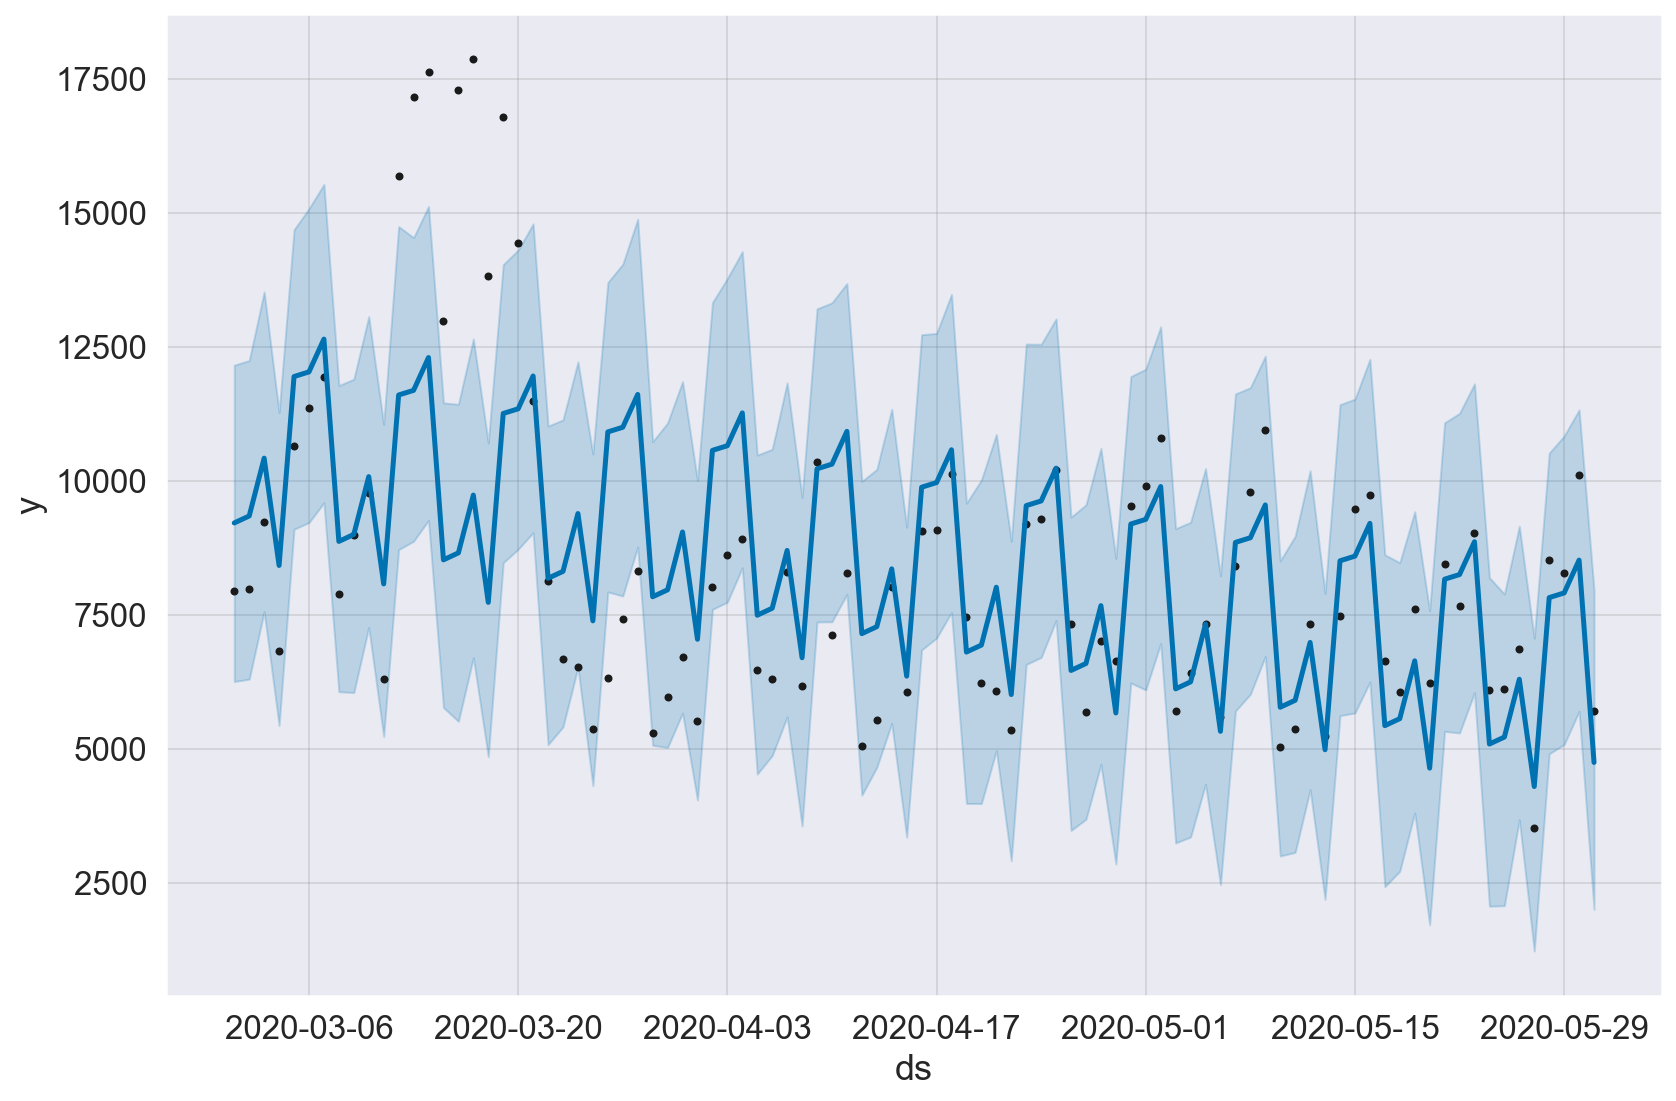

In [22]:
model = Prophet()
model.fit(df_274_sale)
forecast = model.predict(df_274_sale)
model.plot(forecast,figsize=(12,8))

In [23]:
df_274_sale_treino_diario, df_274_sale_teste_diario = dtexp.configura_dataframe_treino_teste(df_274_sale)

## Visualizando a representação dos datasets de treino e de teste sobre o montante total.

In [24]:
iplot(dtview.compare_dataframes_with_scatter(df_274_sale_treino_diario,
                                   df_274_sale_teste_diario,
                                   title='Montante de dados de vendas de Treinamento e Teste',
                                    mode='lines',
                                   name1='Treinamento',
                                   name2='Teste'))

In [25]:
prophet = Prophet()
prophet.fit(df_274_sale_treino_diario)
future_vendas = prophet.make_future_dataframe(periods=7, freq='D')
forecast_vendas = prophet.predict(future_vendas)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


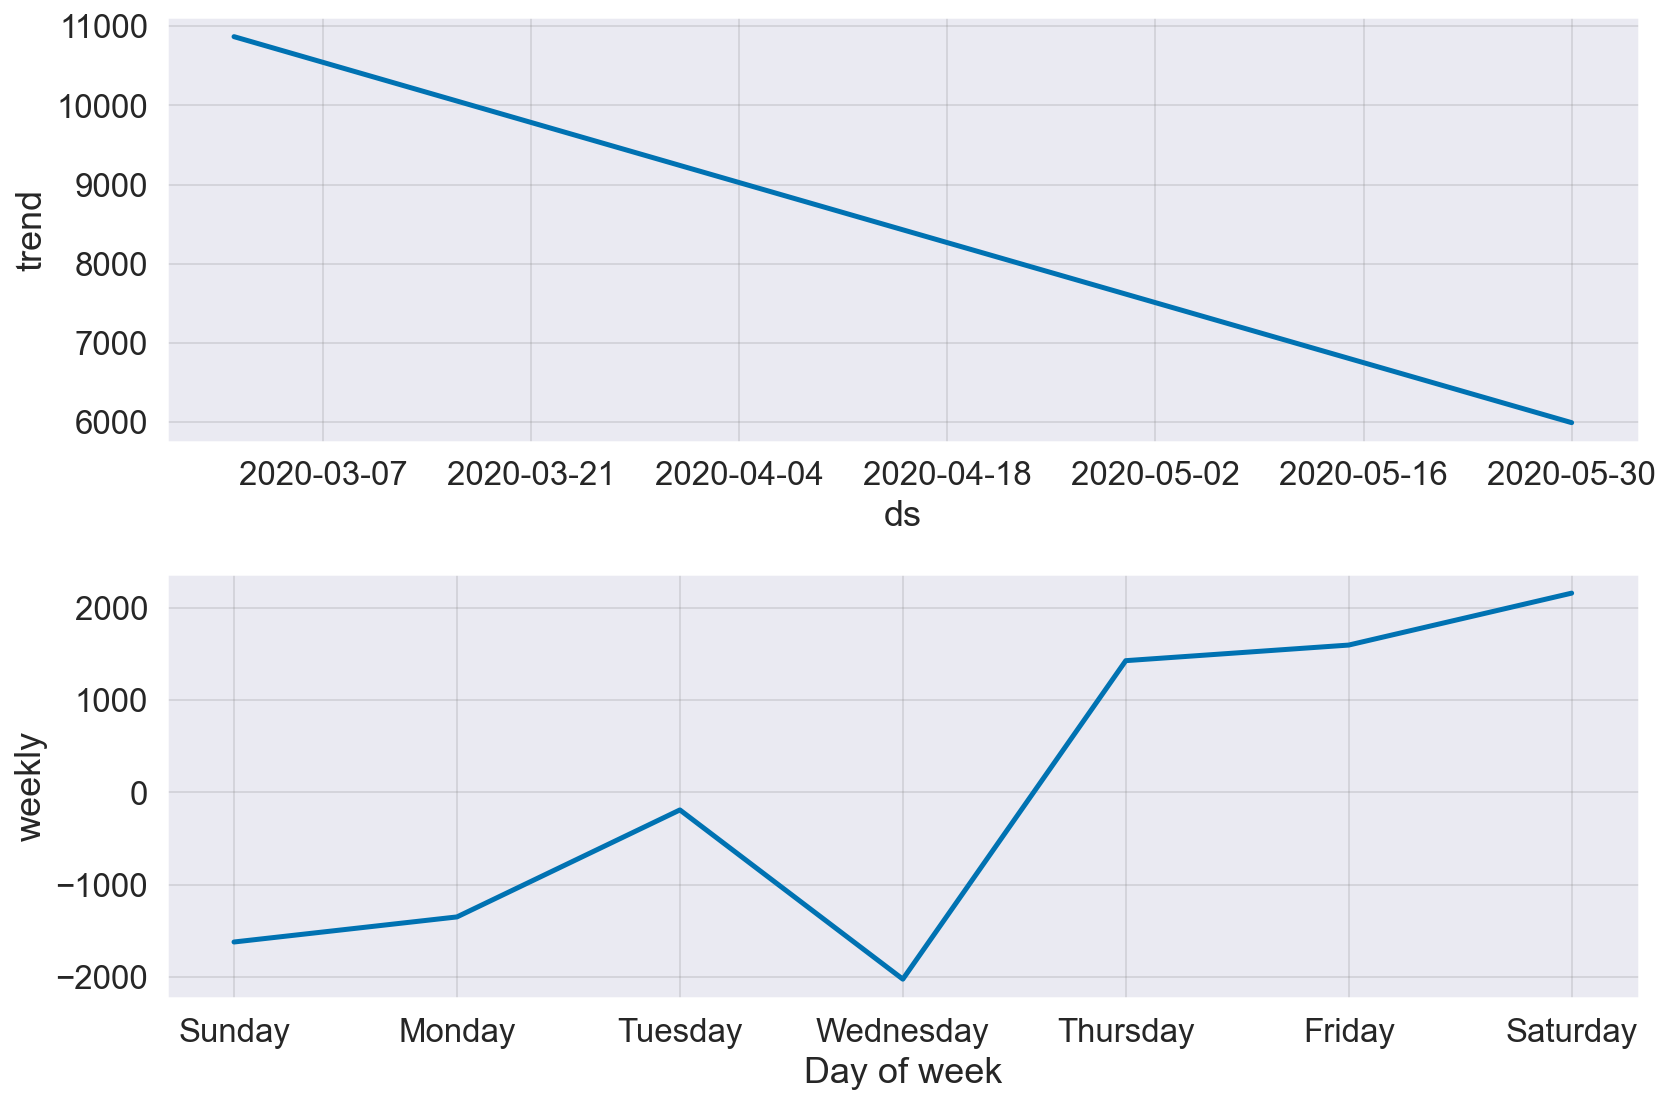

In [26]:
fig = prophet.plot_components(forecast_vendas, figsize=(12,8))


# Modelo Baseado na Decomposição dos Componentes

<div class="alert alert-block alert-info">
<b>Tendência:</b> Os dados apresentam uma tendência de queda da quantidade de produtos vendidos.
<p><b>Componente Semanal:</b> Nesse componente observamos um volume negativo de produtos vendidos entre domingo e quarta.
Isso ocorre em função da sazonalidade semanal e diária que ainda não foi identificada corretamente e as grandes
variações nas quantidades de produtos vendidos entre os meses de março e os seguintes. Esses fatores podem ser os que
apresentam maior influência nesses resultados. Notamos que a quarta-feira, no modelo previsto, mantém o comportamento
identificado anteriormente nos dados reais.</p>
</div>

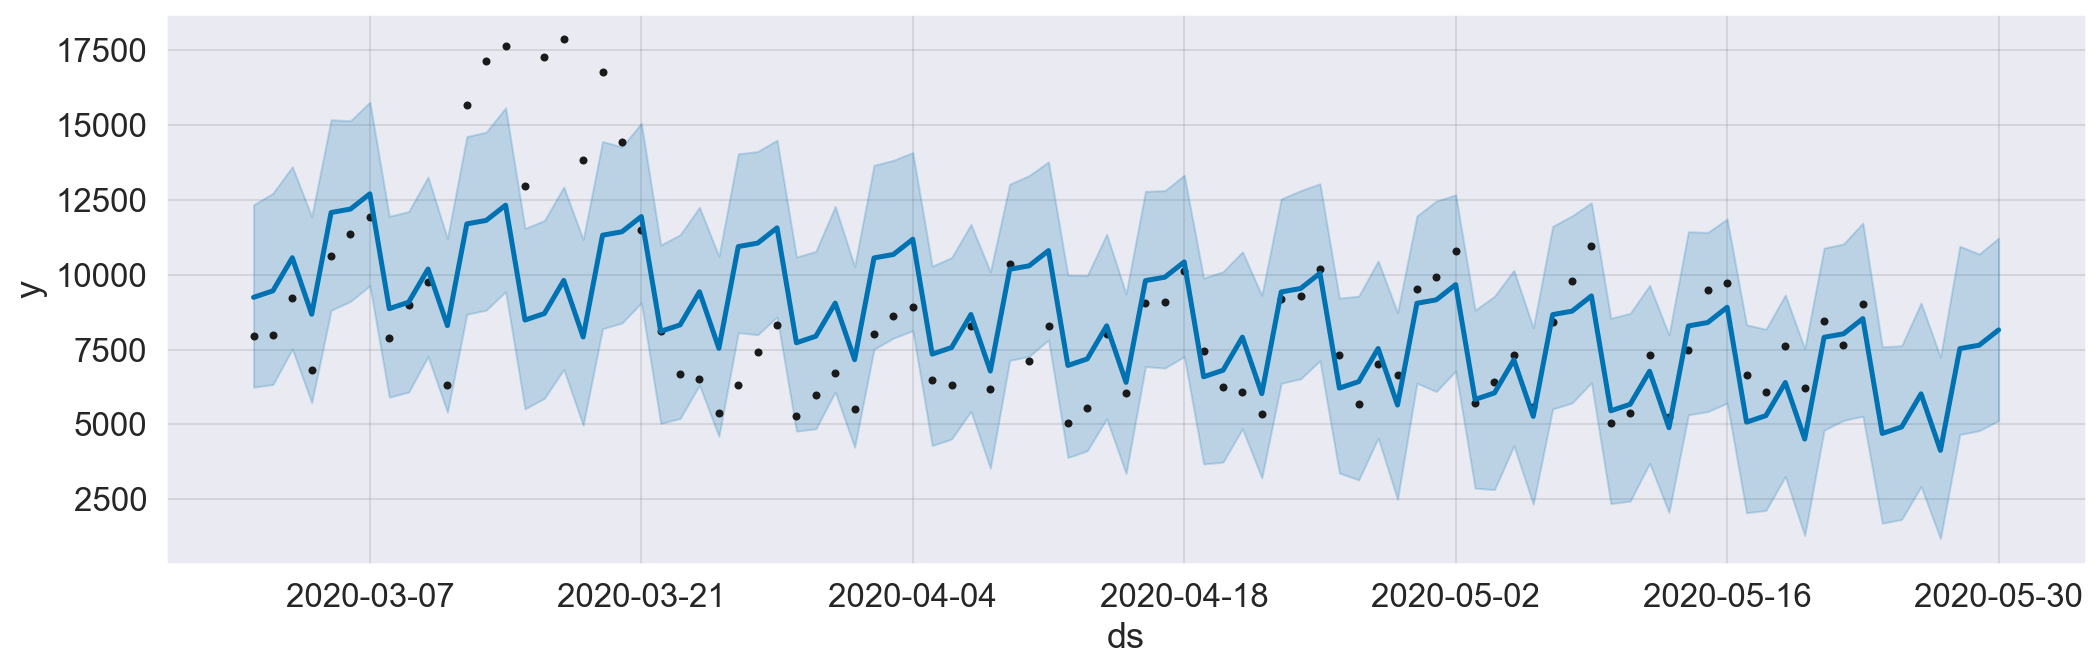

In [27]:
# Visualizando a previsão
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = prophet.plot(forecast_vendas,ax=ax)
plt.show()

<div class="alert alert-block alert-info">
<b>Gráfico do modelo previsto:</b> Os pontos escuros no gráfico representam os dados reais e na altura da segunda semana
de março, observamos dados que escapam do modelo previsto indicando possíveis outliers. As linhas azuis mais escura,
representam a previsão de volumes de produtos vendidos enquanto as linhas mais claras representam o intervalo de
confiança em torno da previsão.
</div>

In [28]:
df_274_sale_teste_diario_forecast = prophet.predict(df_274_sale_teste_diario)

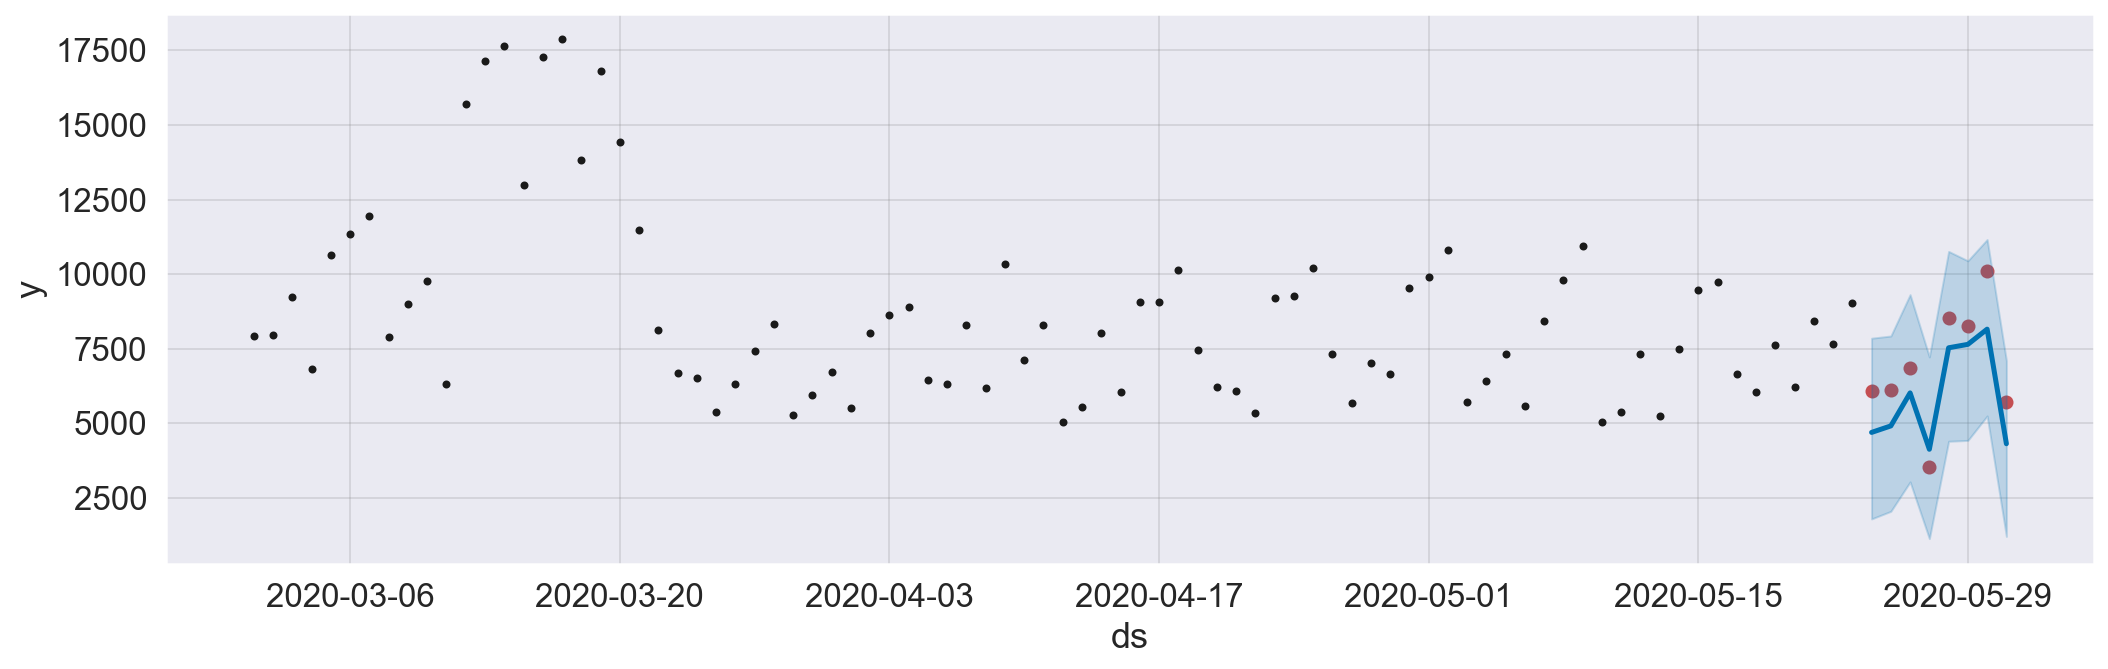

In [29]:
# Visualizando a previsão
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_274_sale_teste_diario.ds,df_274_sale_teste_diario['y'], color='r')
fig = prophet.plot(df_274_sale_teste_diario_forecast,ax=ax)
plt.show()


# Comparação entre as vendas do dataset previsto e as vendas do dataset de teste (vendas realizadas)

In [30]:
iplot(dtview.compare_dataframes_with_scatter(df_274_sale_teste_diario,
                                   df_274_sale_teste_diario_forecast,
                                   title='Previsão de vendas vs Vendas originais realizadas',
                                    mode='lines',
                                   name1='Teste',
                                   name2='Previsto',
                                  is_forecast=True))

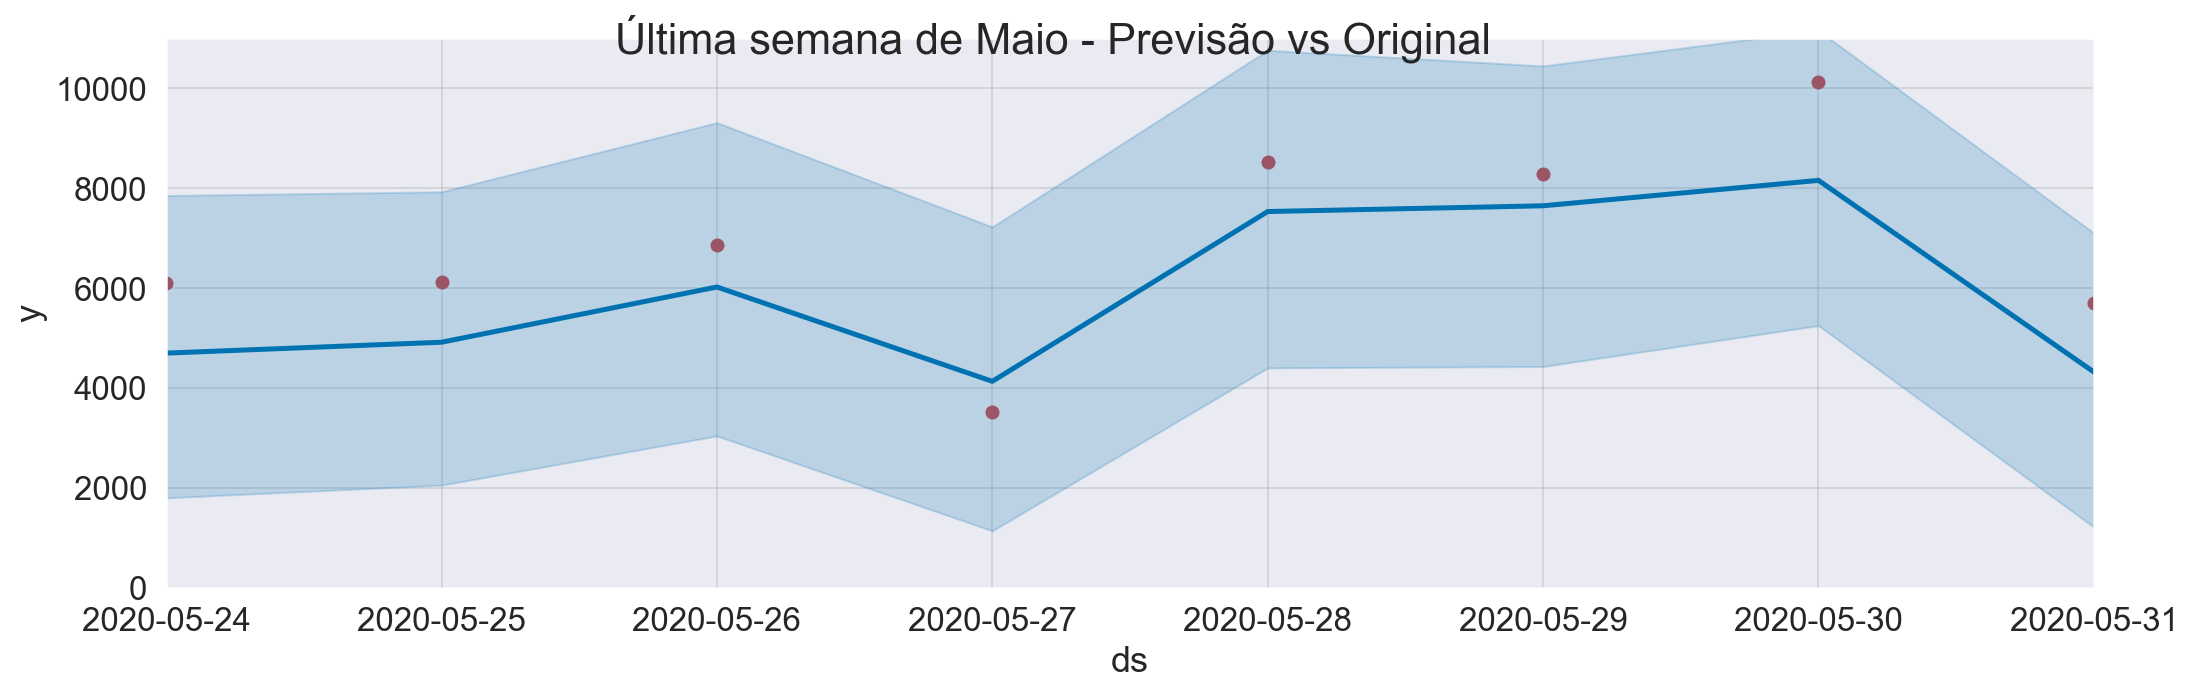

In [31]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_274_sale_teste_diario.ds, df_274_sale_teste_diario['y'], color='r')
fig = prophet.plot(df_274_sale_teste_diario_forecast, ax=ax)
ax.set_xbound(lower='2020-05-24', upper='2020-05-31')
ax.set_ylim(0, 11000)
plot = plt.suptitle('Última semana de Maio - Previsão vs Original')

In [32]:
mape_analysis = []
mape_analysis.append(fm.mape(np.array(df_274_sale_teste_diario['y']),
                                       np.array(df_274_sale_teste_diario_forecast['yhat'])))
print("MAPE ------> {}".format(mape_analysis[0]))


MAPE ------> 0.16899542665715367


In [33]:
iplot(dtview.compare_dataframes_with_bar(
    df_274_sale_teste_diario,
    df_274_sale_teste_diario_forecast,
    nametrace1='Valor Real',
    nametrace2='Valor Previsto',
    idx_end=28))

# Criando novo modelo com os feriados

<div class="alert alert-block alert-info">
<b>Adicionando feriados ao modelo:</b> Vamos verificar se há melhora no MAPE com os feriados adicionados ao novo modelo.
</div>

In [34]:
prophet_feriados = Prophet(holidays=dtclean.get_Holiday())
prophet_feriados.add_country_holidays('BR')
prophet_feriados.fit(df_274_sale_treino_diario)
# Criando as datas futuras previstas pelo prophet
# A frequência especificada em dias (os dados estão em dias)
future_feriados = prophet_feriados.make_future_dataframe(freq='D', periods=7)
# Prevendo os valores
forecast_feriados = prophet_feriados.predict(future_feriados)
# Previsão optimizada dos valores
forecast_feriados = prophet_feriados.predict(future_feriados)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


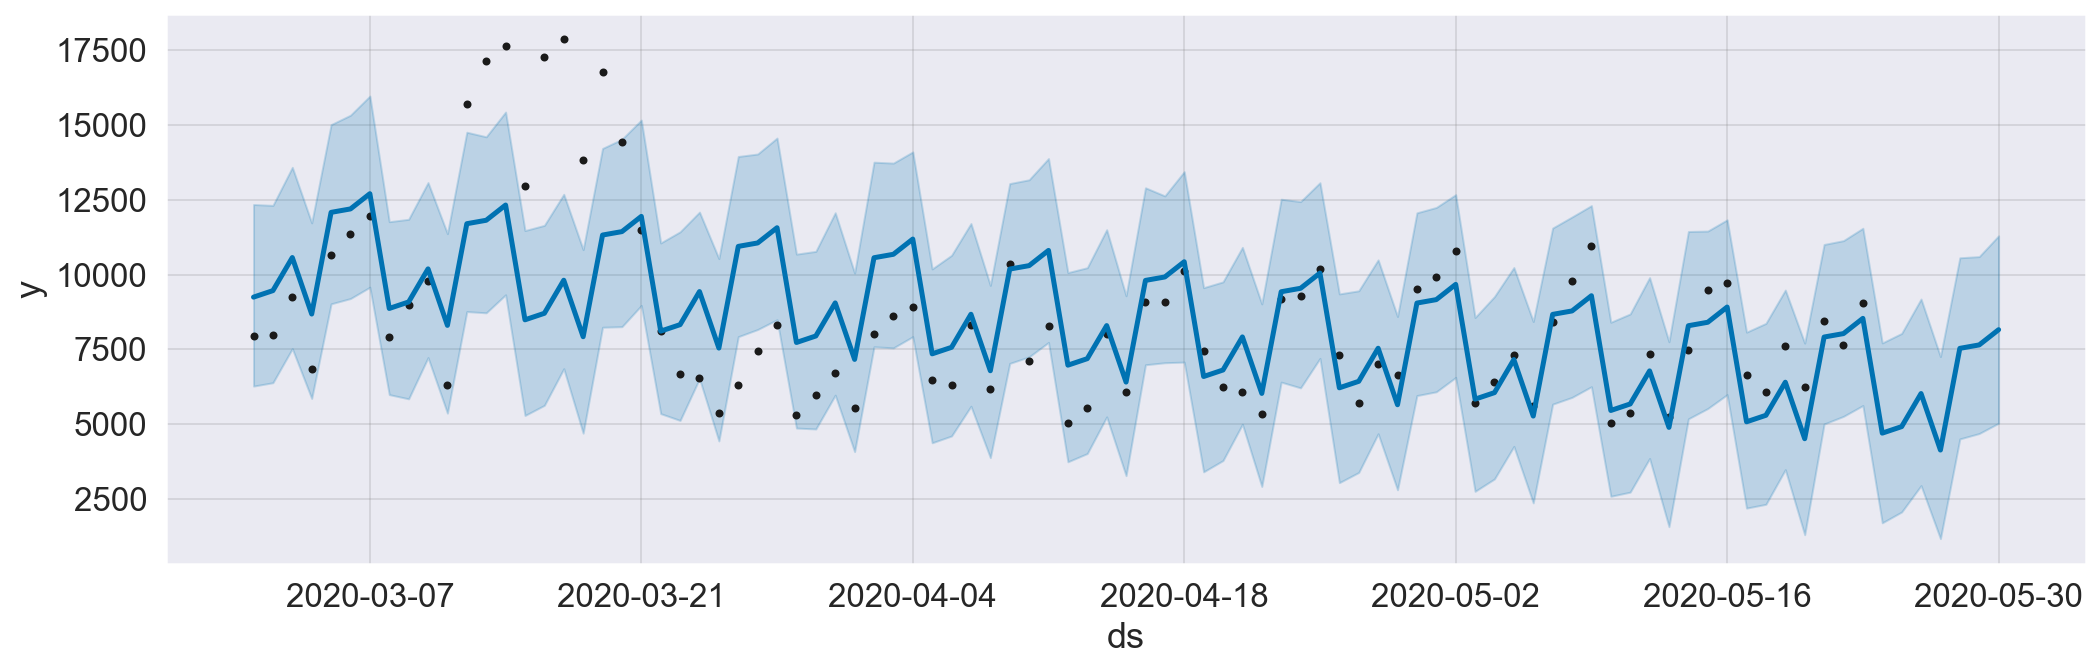

In [35]:
plt,fig_forecast_feriado = dtview.plot_forecast(forecast_feriados,prophet_feriados,f,ax)
plt.show()

<div class="alert alert-block alert-info">
Visualmente não notamos grandes diferenças no gráfico previsto para o novo modelo gerado com feriados. Cabe destacar
que não sabemos os feriados específicos da cidade e sequer eventos que possam impactar na variável em análise, como
dias de jogos de futebol, eventos festivos e etc.
</div>

# Visualizando os componentes do modelo

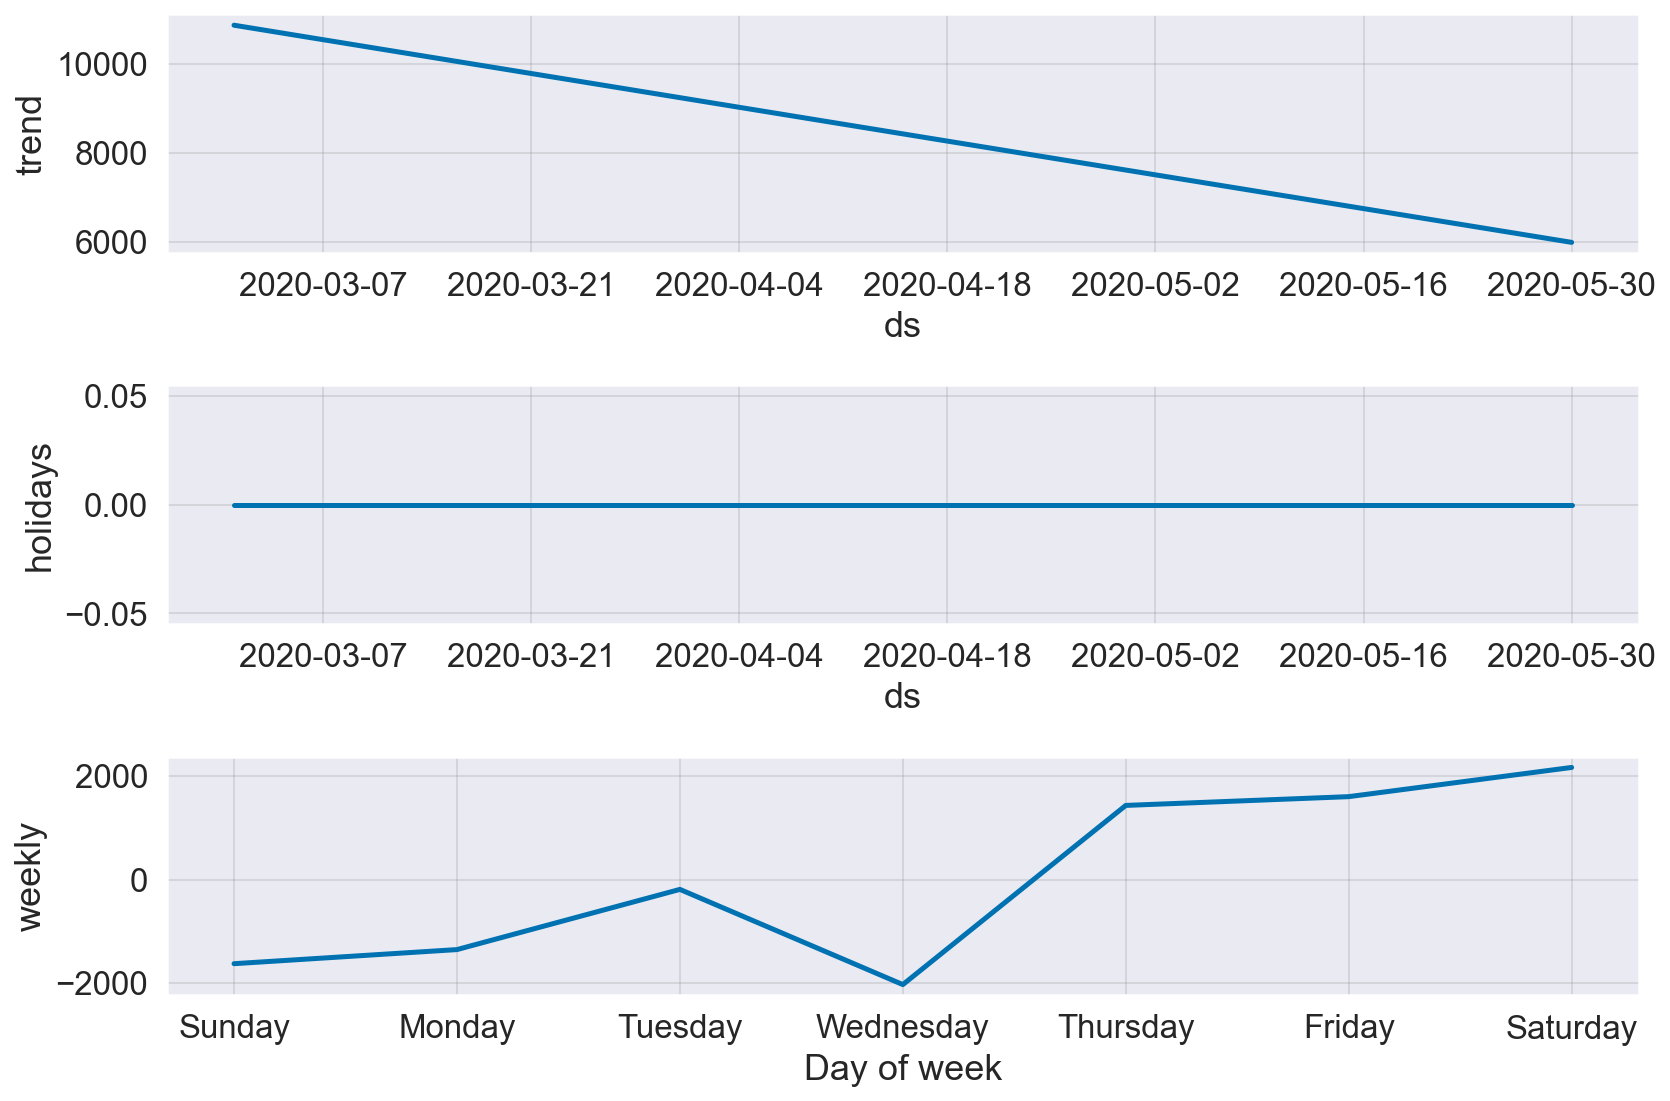

In [36]:
fig_forecast_feriado = prophet_feriados.plot_components(forecast_feriados, figsize=(12,8))

<div class="alert alert-block alert-info">
<b>Componentes:</b> Também não há diferenças nos gráficos de componentes de tendência e semanal, apenas há um novo
componente que representa o feriado onde se espera que não haja vendas nesses dias, contudo, isso pode representar
exatamente o oposto, isto é, a loja funciona nos feriados e há um volume de vendas razoável nos dias que antecedem
o feriado, é preciso saber essa informações para adaptar o modelo.
</div>

In [37]:
forecast_teste_feriados = prophet_feriados.predict(df_274_sale_teste_diario)

## Visualizar dataframe de teste previsto e original com feriados

In [38]:
iplot(dtview.compare_dataframes_with_scatter(
    df_274_sale_teste_diario,
    forecast_teste_feriados,
    title='Dados Previsto vs Original última semana de maio/2020',
    mode='lines',
    name1='Original',
    name2='Previsão com feriados',
    is_forecast=True))

In [39]:
mape_analysis.append(fm.mape(np.array(df_274_sale_teste_diario.y), np.array(forecast_teste_feriados.yhat)))
print("MAPE ------> {}".format(mape_analysis[1]))

MAPE ------> 0.16899542665714887


<div class="alert alert-block alert-info">
Conforme podemos verificar pelo resultado do MAPE, a adição dos feriados não ocasionaram impactos dignos de nota.
</div>

## Treinando o modelo com os melhores parâmetros identificados

+ changepoint_prior_scale= 10
+ holidays_prior_scale = 0.3
+ n_changepoints = 30
+ seasonality_mode = 'multiplicative'
+ seasonality_prior_scale = 15,20,25

In [40]:
# Configurando e treinando o modelo com feriados e parâmetros otimizados
final_prophet = Prophet(holidays=dtclean.get_Holiday(),
                      changepoint_prior_scale= 10,
                      holidays_prior_scale = 0.3,
                      n_changepoints = 30,
                      seasonality_mode = 'multiplicative',
                      seasonality_prior_scale = 15,
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
final_prophet.add_country_holidays(country_name='BR')
final_prophet.fit(df_274_sale_treino_diario)

In [41]:
future_final = final_prophet.make_future_dataframe(periods=7, freq='D')
forecast_final = final_prophet.predict(future_final)

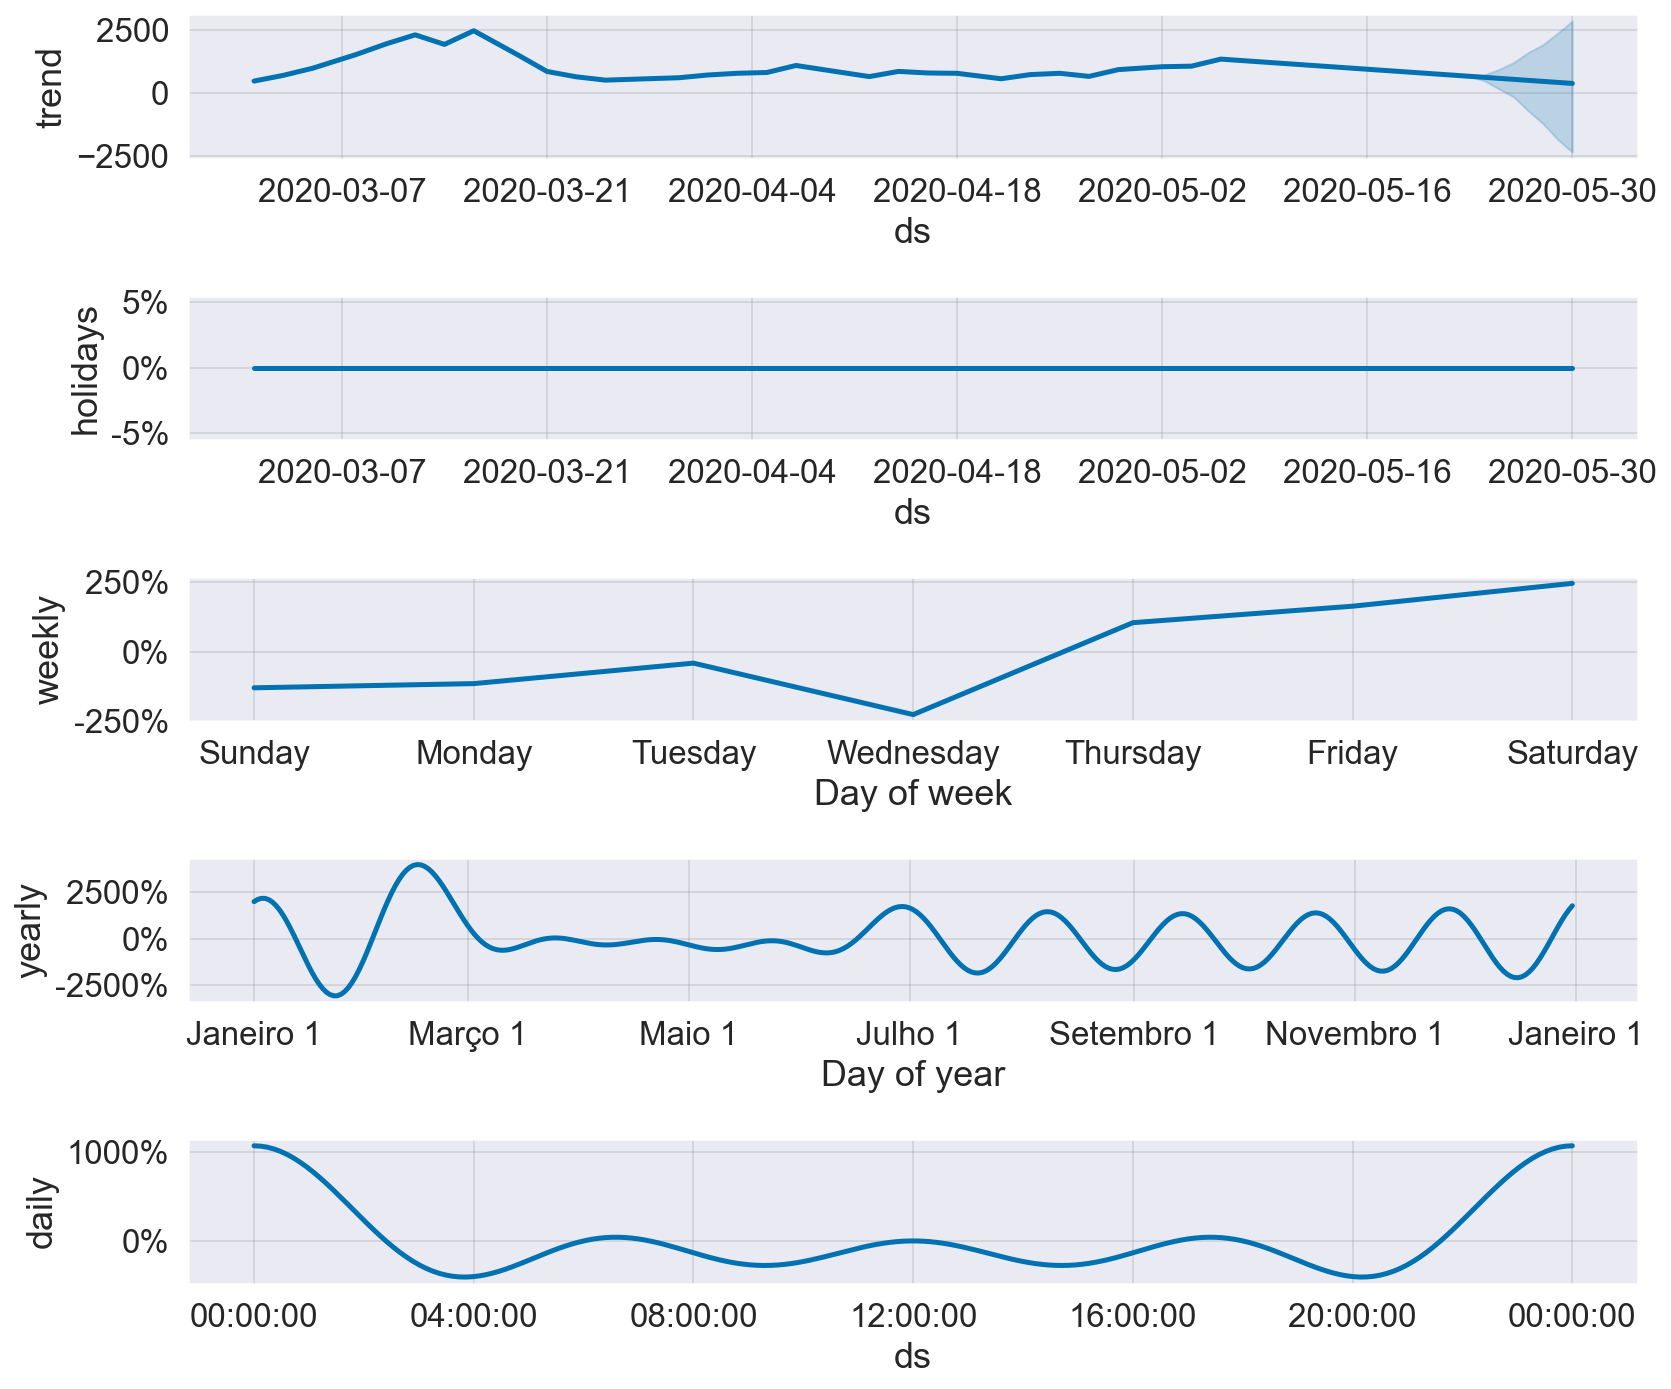

In [42]:
# Visualizando os componentes do modelo
fig = final_prophet.plot_components(forecast_final, figsize=(12,10))

<div class="alert alert-block alert-info">
Na plotagem dos componentes, observamos que o eixo y teve uma redução. Esse eixo representa o quanto o dia da semana
afeta ou impacta na previsão, antes dos parâmetros tunados e sem adição dos feriados, era superior a 2000 % e agora
reduziu para 250%. Entre domingo e quinta-feira há uma variação que supera 250% para a sazonalidade semanal e
na sazonalidade anual, há uma variação superior a 5000% entre fevereiro em março, essas variações são as responsáveis
por verificarmos valores negativos na previsão. Um teste para tratar essa situaçõa poderá ser separar o dataset em semana
útil e fins de semana, para verificar se há melhora na acurácia e remoção dos valores negativos.
</div>

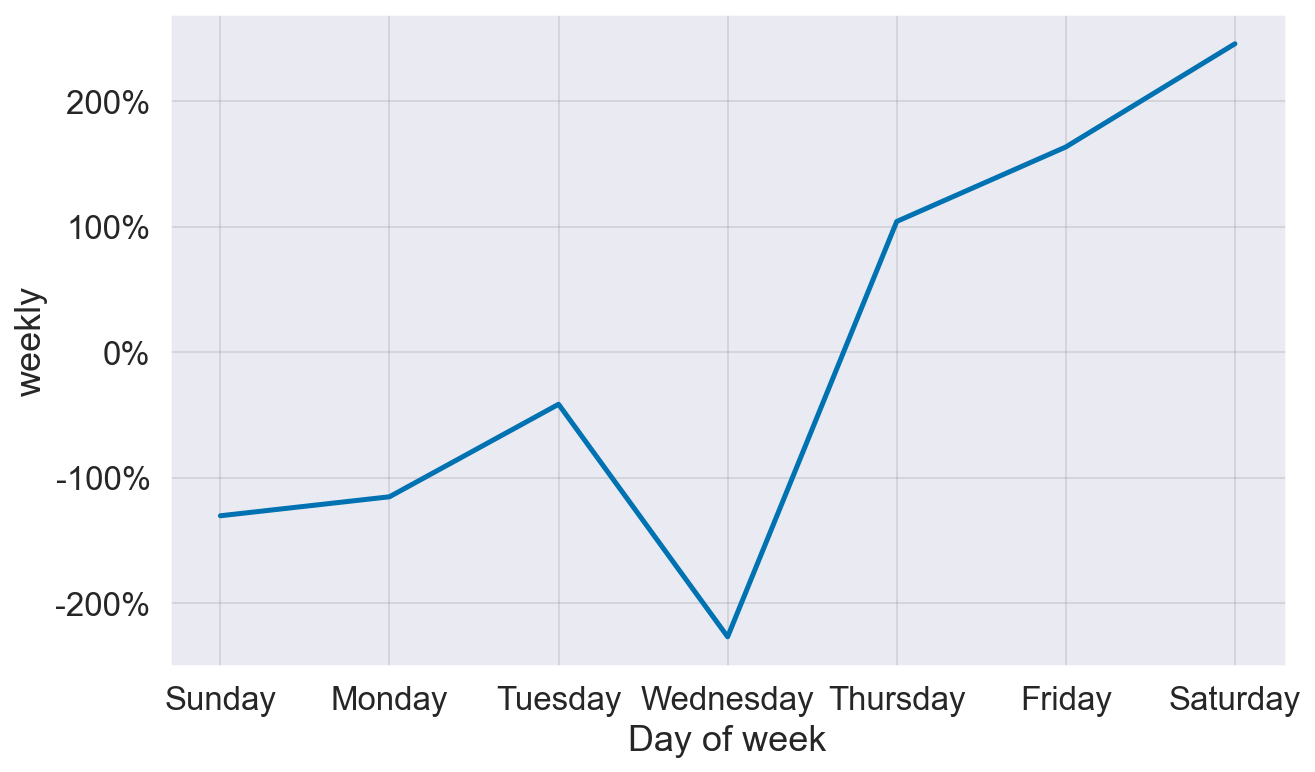

In [43]:
from fbprophet.plot import plot_weekly

fig_w = plot_weekly(final_prophet)

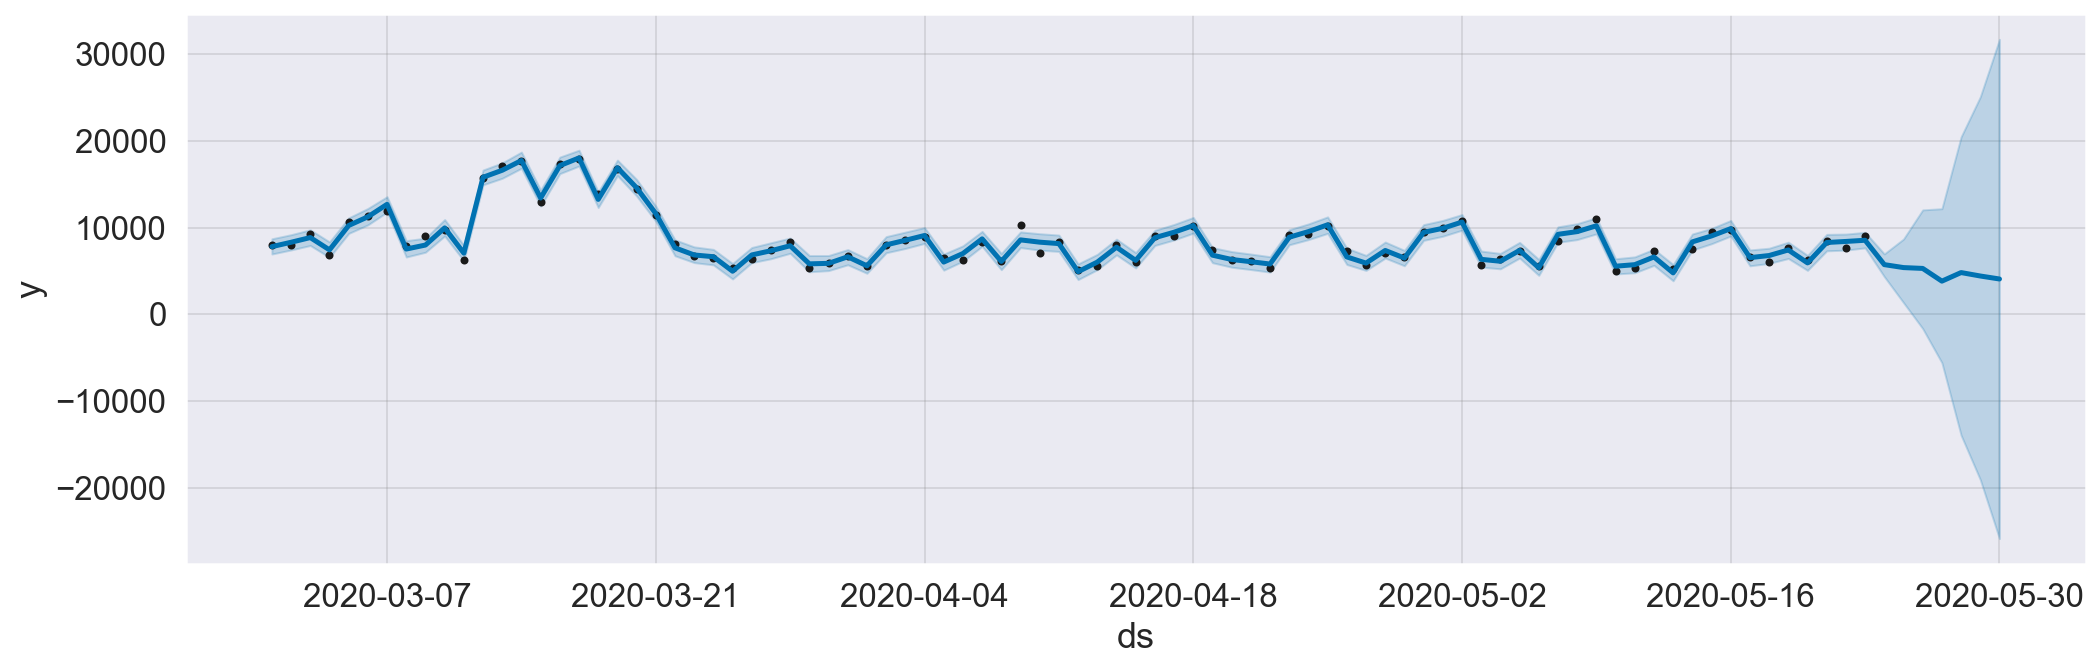

In [44]:
# Visualizando a previsão
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = final_prophet.plot(forecast_final,ax=ax)
plt.show()

In [45]:
df_teste_final= final_prophet.predict(df_274_sale_teste_diario)

In [46]:
iplot(dtview.compare_dataframes_with_scatter(df_274_sale_teste_diario,
                                   df_teste_final,
                                   title='Previsão de vendas vs Vendas originais realizadas',
                                    mode='lines',
                                   name1='Teste',
                                   name2='Previsto',
                                  is_forecast=True))

In [47]:
iplot(dtview.compare_dataframes_with_bar(
    df_274_sale_teste_diario,
    df_teste_final,
    nametrace1='Teste',
    nametrace2='Previsto'))

In [48]:
mape_analysis.append(fm.mape(np.array(df_274_sale_teste_diario.y), np.array(df_teste_final.yhat)))
print("MAPE -----> {}".format(mape_analysis[2]))

MAPE -----> 0.3272175767856876


# Identificando os outliers

In [49]:
dtview.check_outliers_univariate(df_274_sale)

In [50]:
df_sem_outliers = df_274_sale[df_274_sale['y'] < 15689]

In [51]:
df_274_sem_outliers_treino, df_274_sem_outliers_teste = dtexp.configura_dataframe_treino_teste(df_sem_outliers)

In [52]:
iplot(dtview.compare_dataframes_with_scatter(df_274_sem_outliers_treino,
                                   df_274_sem_outliers_teste,
                                   title='Montante de dados de vendas de Treinamento e Teste (sem outliers)',
                                    mode='lines',
                                   name1='Treinamento',
                                   name2='Teste'))

In [53]:
prophet_no_outliers = Prophet()
prophet_no_outliers.fit(df_274_sem_outliers_treino)
future_no_outliers = prophet_no_outliers.make_future_dataframe(periods=7, freq='D')
forecast_no_outliers = prophet_no_outliers.predict(future_no_outliers)

iplot(dtview.plot_forecast_as_table(forecast_no_outliers))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


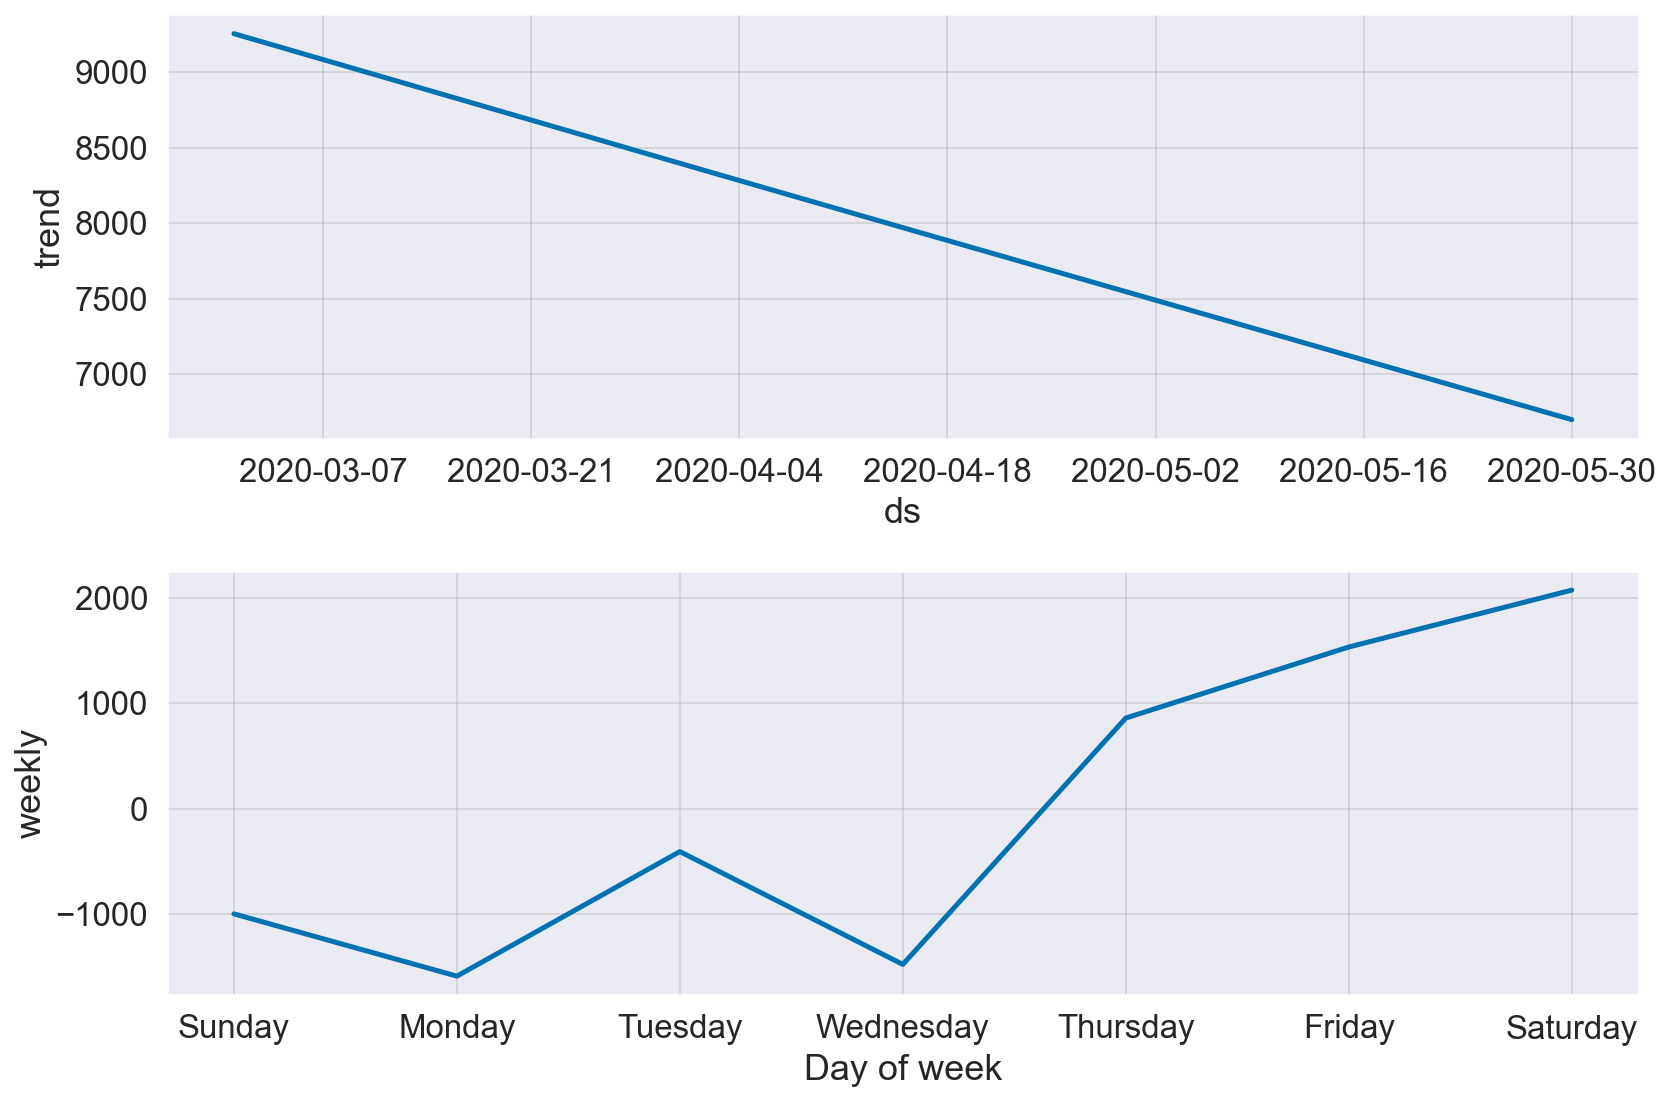

In [54]:
# Visualizando os componentes

fig = prophet_no_outliers.plot_components(forecast_no_outliers, figsize=(12,8))


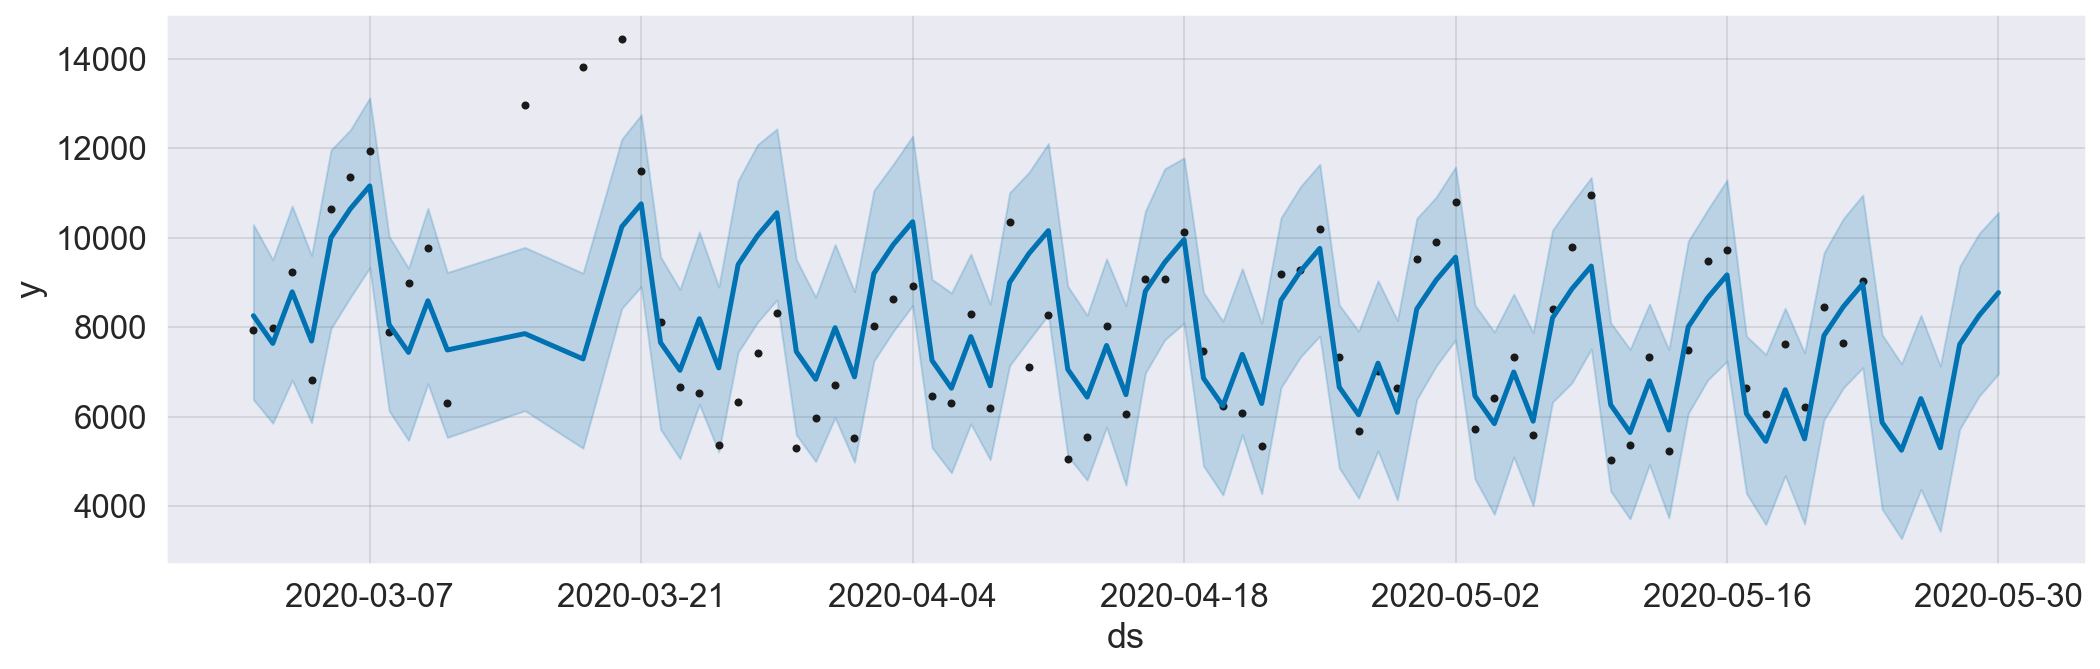

In [55]:
# Visualizando a previsão
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = prophet_no_outliers.plot(forecast_no_outliers,ax=ax)
plt.show()

In [56]:
df_274_no_outliers_teste_forecast = prophet_no_outliers.predict(df_274_sem_outliers_teste)

In [57]:
iplot(dtview.compare_dataframes_with_scatter(df_274_sem_outliers_teste,
                                   df_274_no_outliers_teste_forecast,
                                   title='Previsão de vendas vs Vendas originais realizadas',
                                    mode='lines',
                                   name1='Teste',
                                   name2='Previsto',
                                  is_forecast=True))

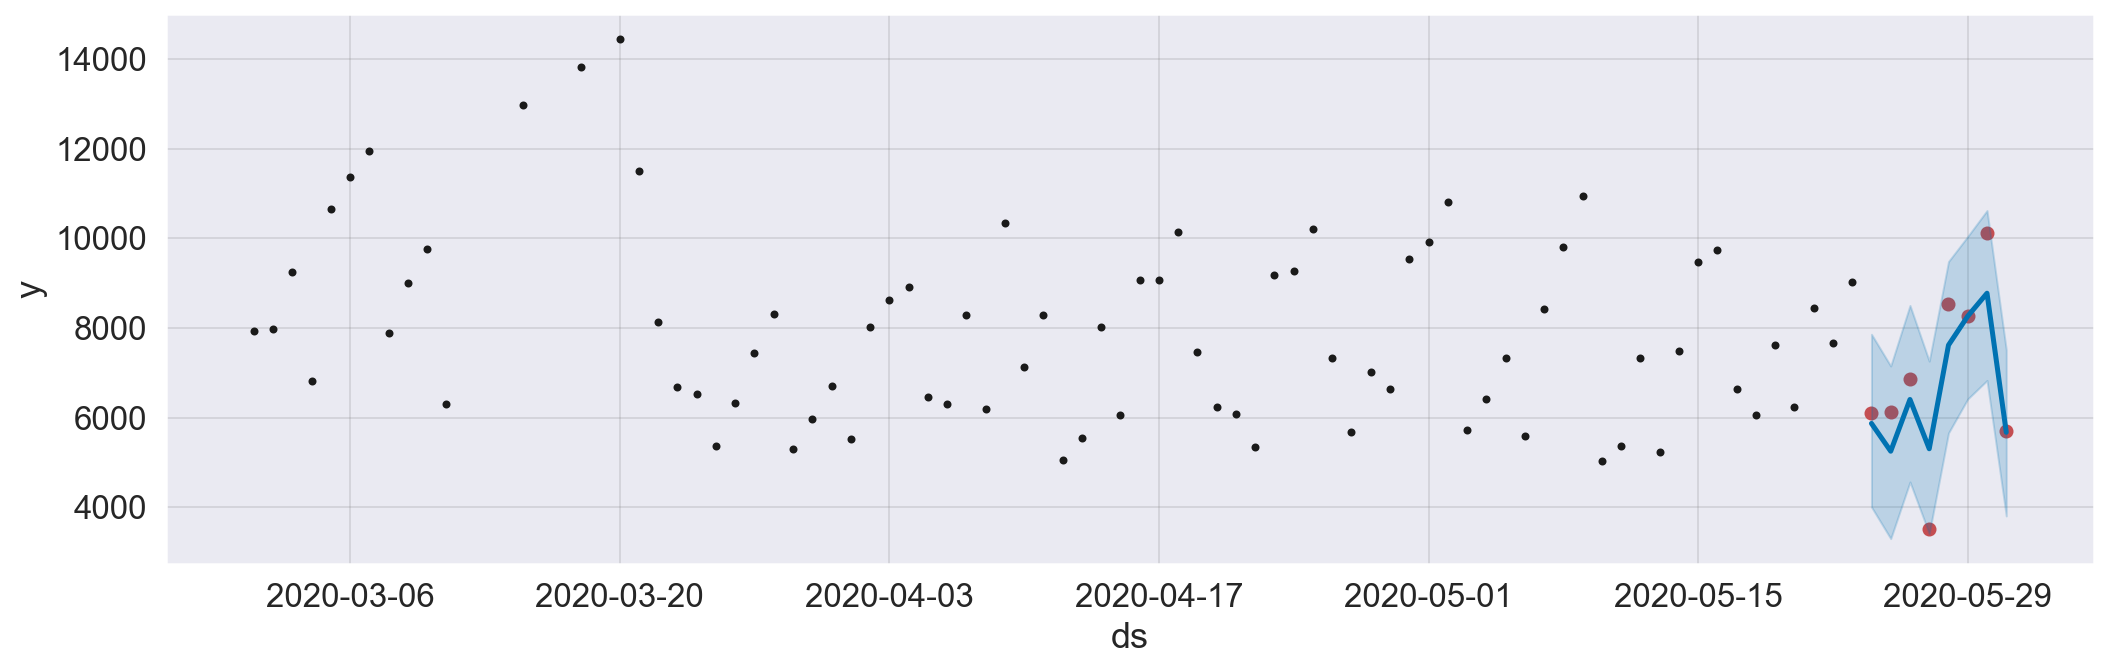

In [58]:
# Visualizando a previsão
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_274_sem_outliers_teste.ds,df_274_sem_outliers_teste['y'], color='r')
fig = prophet_no_outliers.plot(df_274_no_outliers_teste_forecast,ax=ax)
plt.show()

## Comparando os dados previsto com os realizados

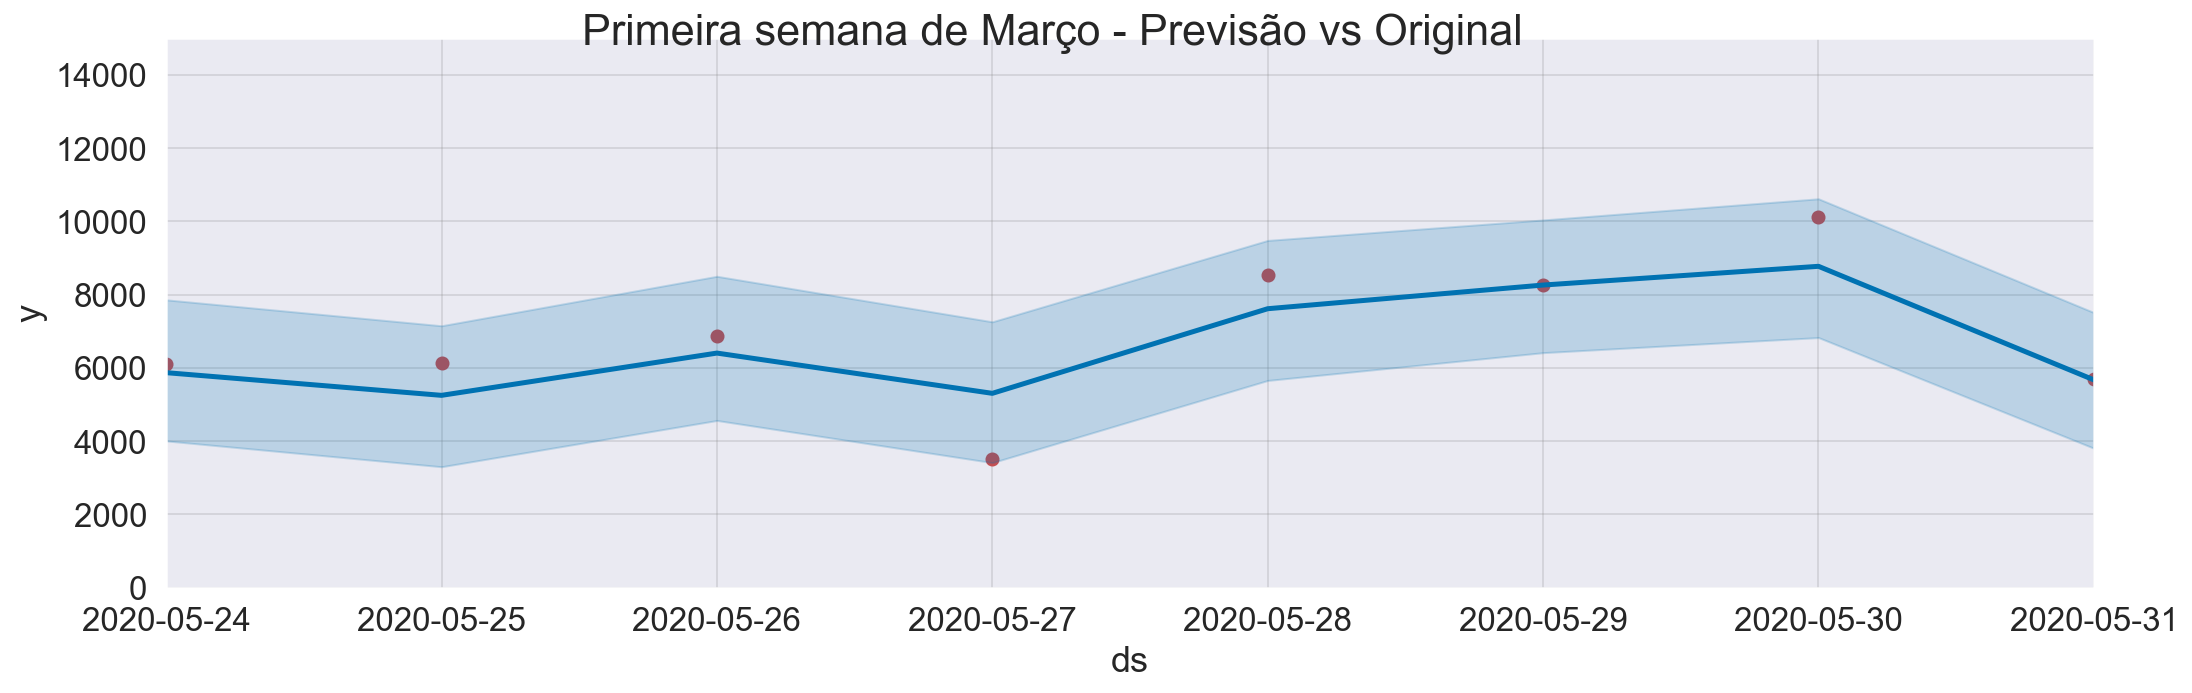

In [59]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_274_sem_outliers_teste.ds, df_274_sem_outliers_teste['y'], color='r')
fig = prophet_no_outliers.plot(df_274_no_outliers_teste_forecast, ax=ax)
ax.set_xbound(lower='2020-05-24', upper='2020-05-31')
ax.set_ylim(0, 15000)
plot = plt.suptitle('Primeira semana de Março - Previsão vs Original')

In [60]:
iplot(dtview.compare_dataframes_with_bar(
        df_274_sem_outliers_teste,
        df_274_no_outliers_teste_forecast,
        nametrace1='Valor Real (sem outliers)',
        nametrace2='Valor Previsto (sem outliers)',
        idx_end=28))

In [61]:
mape_analysis.append(fm.mape(np.array(df_274_sem_outliers_teste.y),
                               np.array(df_274_no_outliers_teste_forecast.yhat)))
print("MAPE -----> {}".format(mape_analysis[3]))


MAPE -----> 0.12482887010004967


In [62]:
prophet_feriados_s_outliers = Prophet(holidays=dtclean.get_Holiday())

prophet_feriados_s_outliers.add_country_holidays('BR')
prophet_feriados_s_outliers.fit(df_274_sem_outliers_treino)
# Criando as datas futuras previstas pelo prophet
# A frequência especificada em dias (os dados estão em dias)
future_feriados_s_outliers = prophet_feriados_s_outliers.make_future_dataframe(freq='D', periods=7)
# Prevendo os valores
forecast_feriados_s_outliers = prophet_feriados_s_outliers.predict(future_feriados_s_outliers)
# Previsão optimizada dos valores
future_feriados_s_outliers = prophet_feriados_s_outliers.predict(future_feriados_s_outliers)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


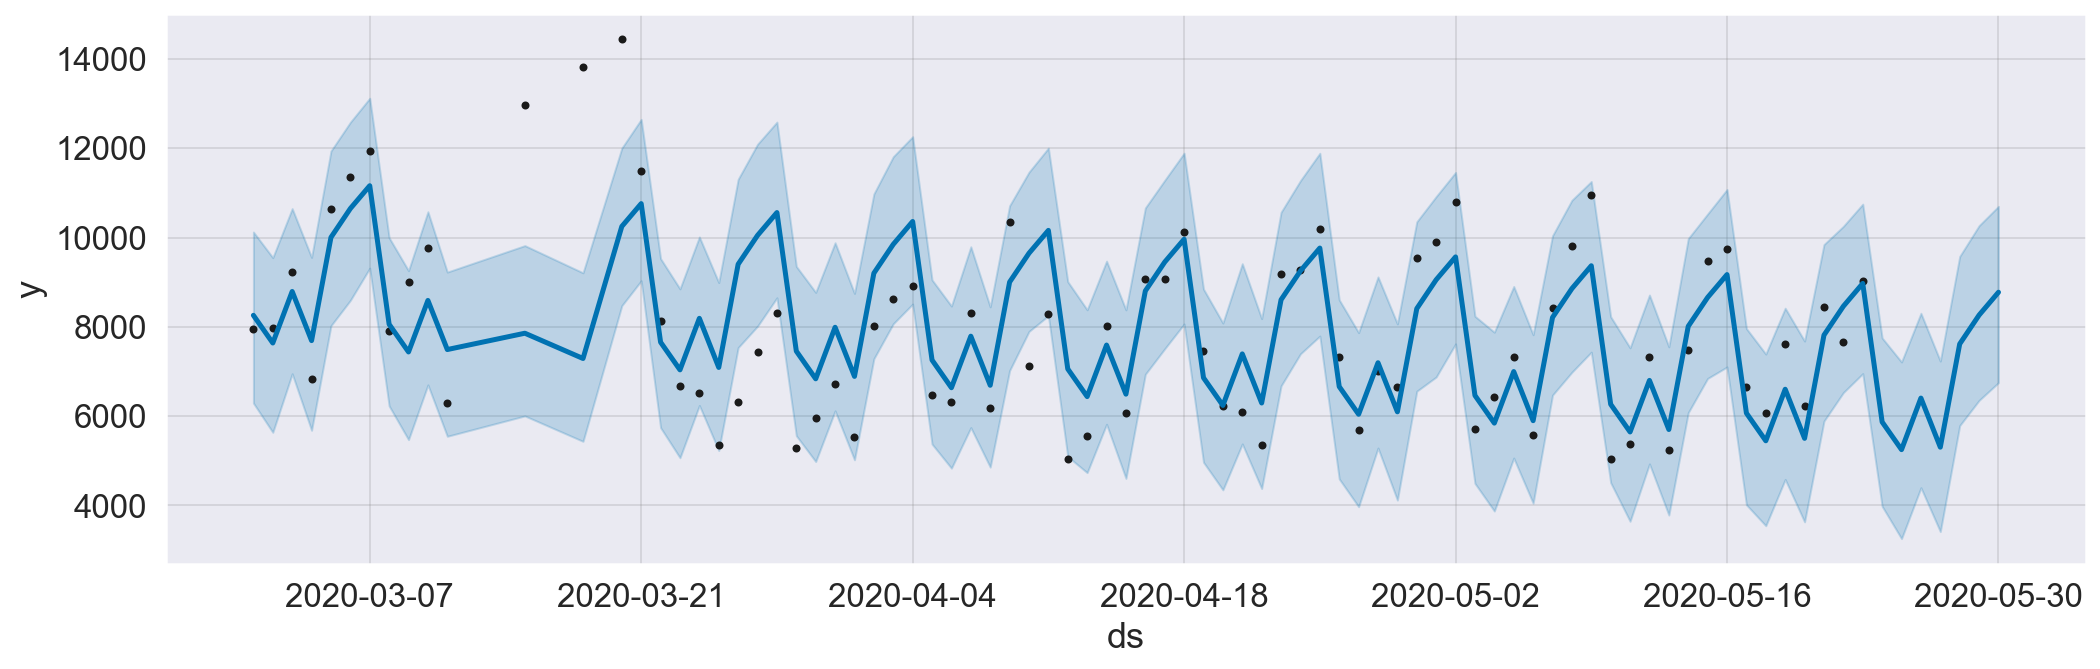

In [63]:
plt,fig_forecast_feriado_s_outliers = dtview.plot_forecast(future_feriados_s_outliers,prophet_feriados_s_outliers,f,ax)
plt.show()

# Visualizando os componentes do modelo

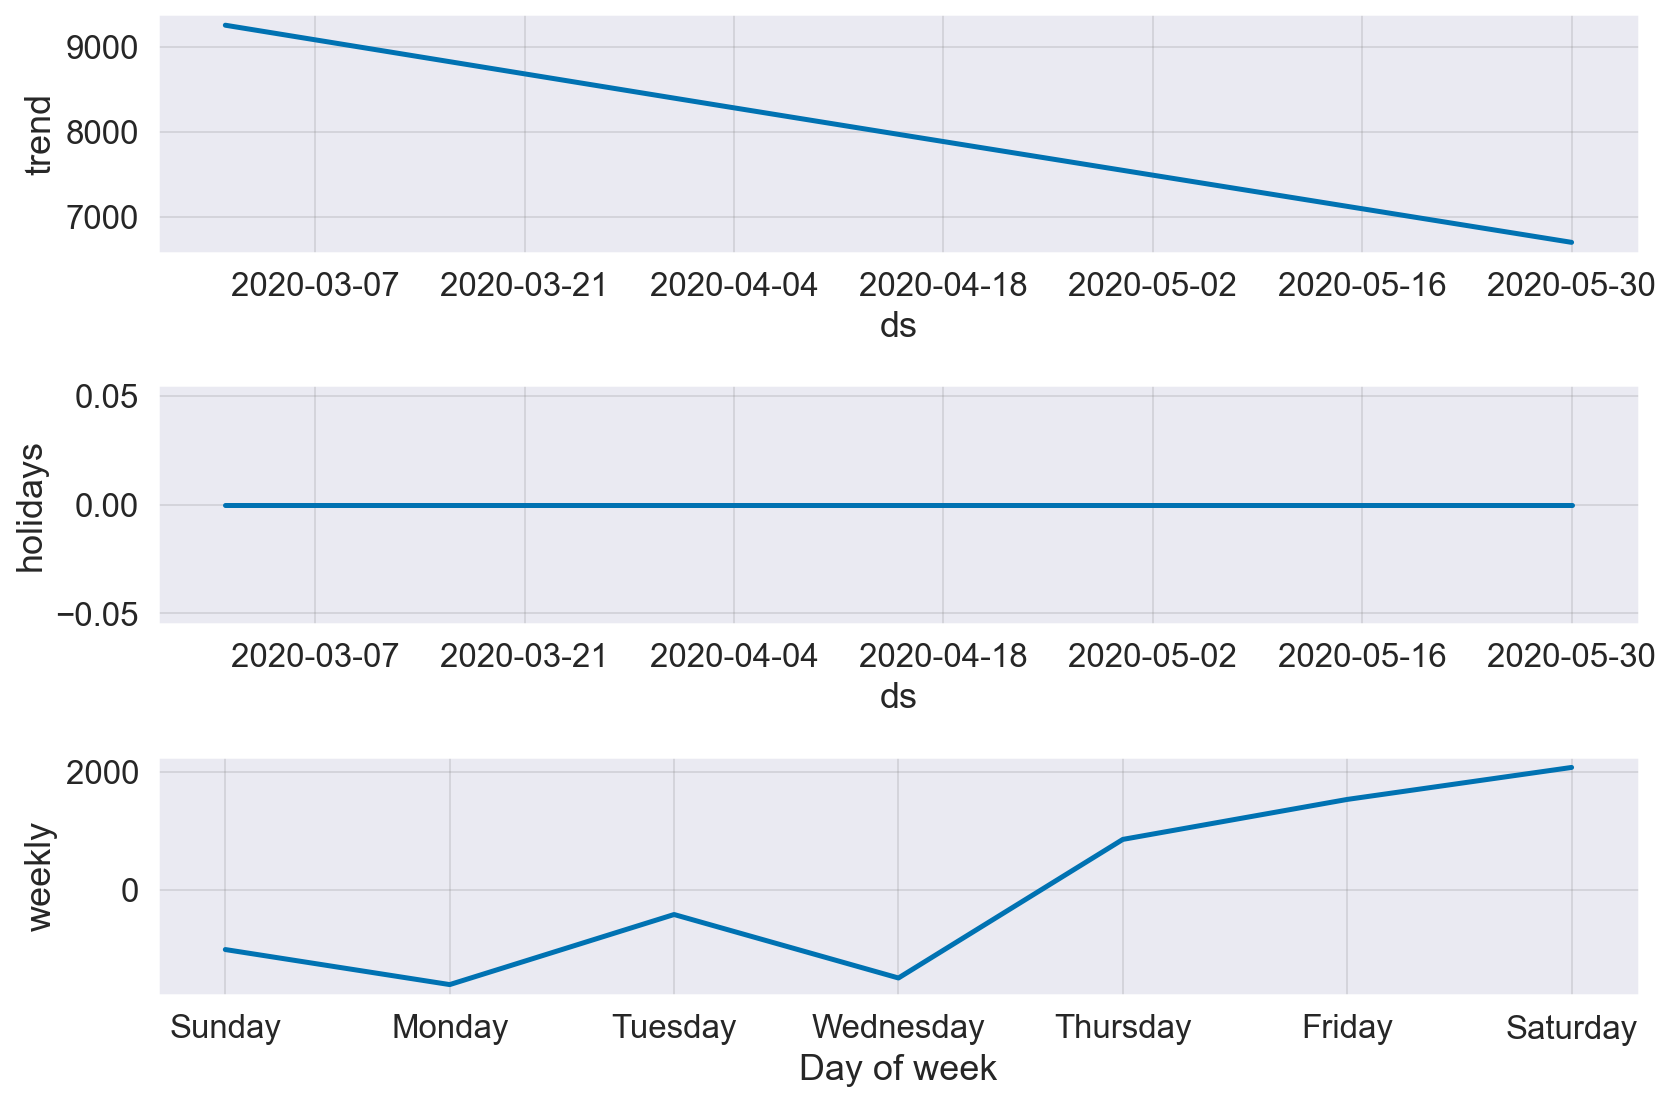

In [64]:
fig_forecast_feriado_s_outliers = prophet_feriados_s_outliers.plot_components(forecast_feriados_s_outliers,figsize=(12,8))

In [65]:
forecast_teste_feriados_s_outliers = prophet_feriados_s_outliers.predict(df_274_sem_outliers_teste)
iplot(dtview.plot_forecast_as_table(forecast_teste_feriados_s_outliers))

# Visualizar dataframe de teste previsto e original com feriados

In [66]:
iplot(dtview.compare_dataframes_with_scatter(
    df_274_sem_outliers_teste,
    forecast_teste_feriados_s_outliers,
    title='Dados Previsto vs Original última semana de maio/2020',
    mode='lines',
    name1='Original',
    name2='Previsão com feriados',
    is_forecast=True))

In [67]:
iplot(dtview.compare_dataframes_with_bar(
        df_274_sem_outliers_teste,
        forecast_teste_feriados_s_outliers,
        nametrace1='Original',
        nametrace2='Previsão com feriados',
        idx_end=28))

In [68]:
mape_analysis.append(fm.mape(np.array(df_274_sem_outliers_teste['y']),
                     np.array(forecast_teste_feriados_s_outliers['yhat'])))
print("MAPE -----> {}".format(mape_analysis[4]))


MAPE -----> 0.12482887010004917


# Configurando e treinando o modelo com feriados e parâmetros otimizados

In [69]:
final_prophet_s_outliers = Prophet(holidays=dtclean.get_Holiday(),
                      changepoint_prior_scale= 10,
                      holidays_prior_scale = 0.3,
                      n_changepoints = 30,
                      seasonality_mode = 'multiplicative',
                      seasonality_prior_scale = 25,
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
final_prophet_s_outliers.add_country_holidays(country_name='BR')
final_prophet_s_outliers.fit(df_274_sem_outliers_treino)

In [70]:
future_final_s_outliers = final_prophet_s_outliers.make_future_dataframe(periods=7, freq='D')
forecast_final_s_outliers = final_prophet_s_outliers.predict(future_final_s_outliers)
iplot(dtview.plot_forecast_as_table(forecast_final_s_outliers))

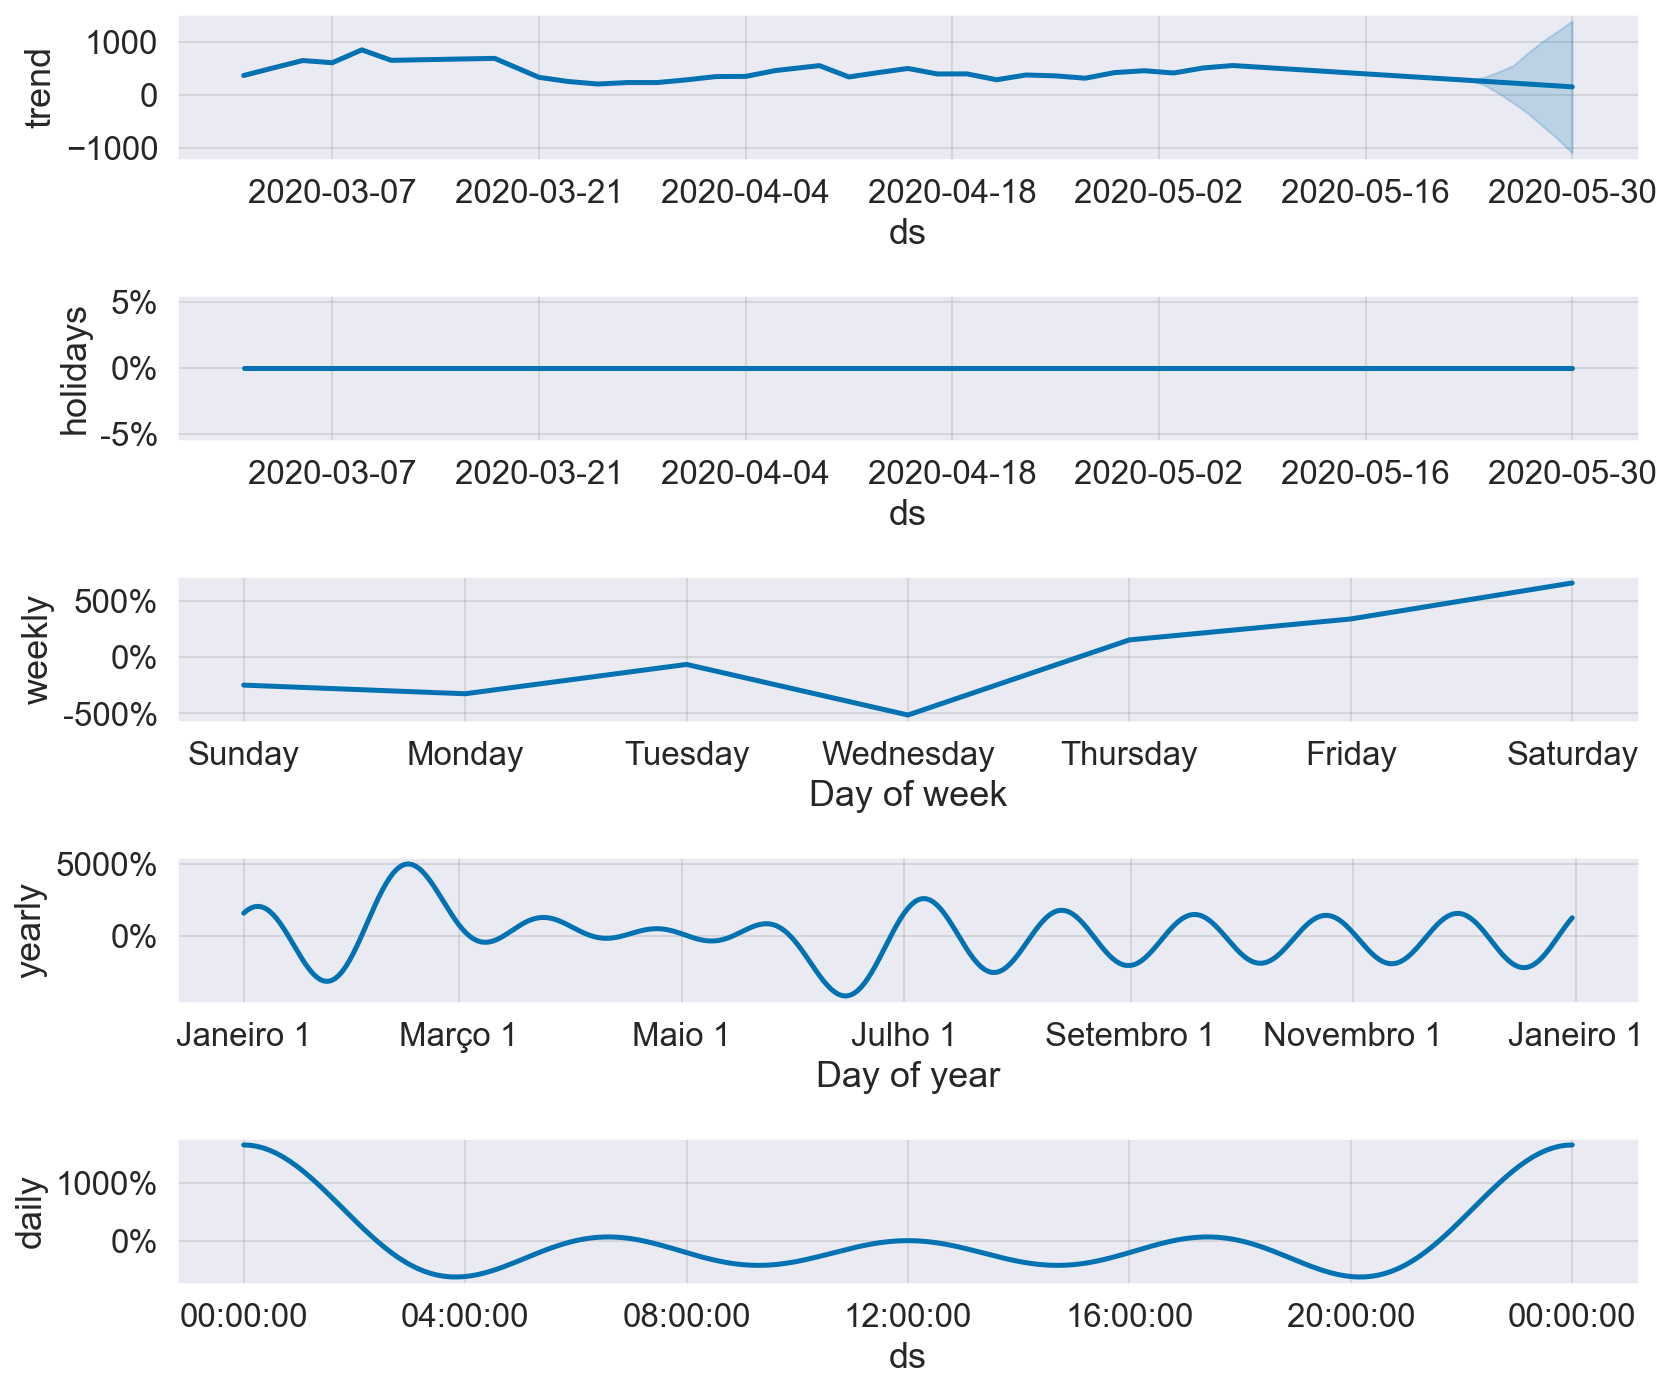

In [71]:
# Visualizando os componentes do modelo
fig = final_prophet_s_outliers.plot_components(forecast_final_s_outliers, figsize=(12,10))

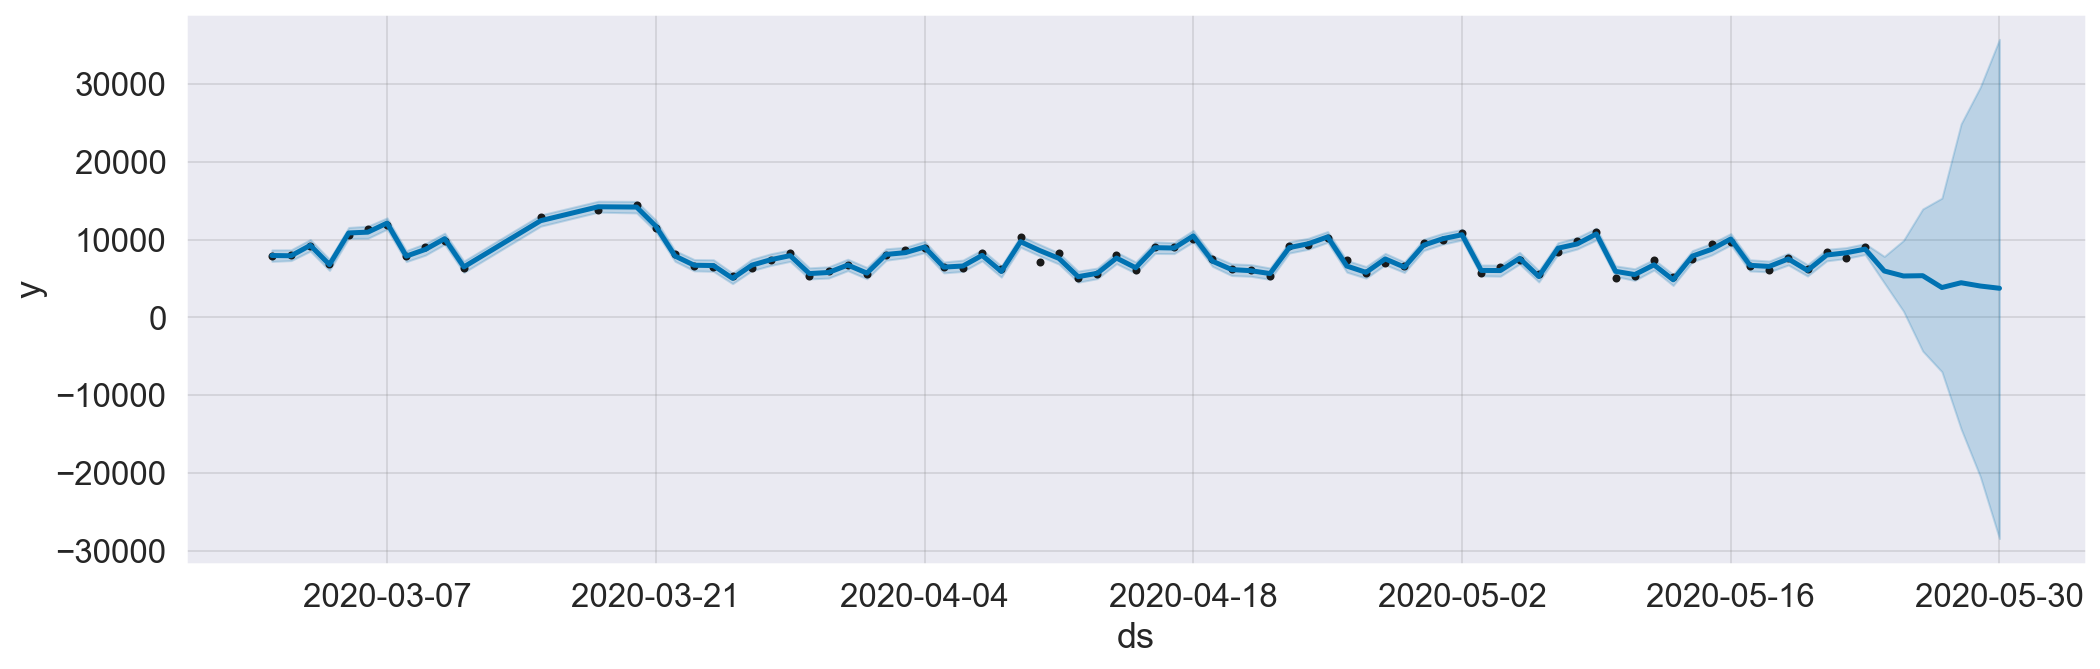

In [72]:
# Visualizando a previsão
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = final_prophet_s_outliers.plot(forecast_final_s_outliers,ax=ax)
plt.show()

In [73]:
df_teste_final_s_outliers= final_prophet_s_outliers.predict(df_274_sem_outliers_teste)


## Comparando os dados previstos com os realizados

In [74]:
iplot(dtview.compare_dataframes_with_scatter(df_274_sem_outliers_teste,
                                   df_teste_final_s_outliers,
                                   title='Previsão de vendas vs Vendas originais realizadas',
                                    mode='lines',
                                   name1='Teste',
                                   name2='Previsto',
                                  is_forecast=True))

In [75]:
iplot(dtview.compare_dataframes_with_bar(
    df_274_sem_outliers_teste,
    df_teste_final_s_outliers,
    nametrace1='Teste',
    nametrace2='Previsto'))

In [76]:
mape_analysis.append(fm.mape(np.array(df_274_sem_outliers_teste['y']),
                     np.array(df_teste_final_s_outliers['yhat'])))

print("MAPE -----> {}".format(mape_analysis[5]))

MAPE -----> 0.3451345117197922


In [77]:
mape_keys = ['inicial','feriados','parametros','outliers','outliers feriados','outliers params']
mape_vendas_diarias = dict(zip(mape_keys,mape_analysis))
iplot(dtview.plot_results(
    list(mape_vendas_diarias.keys()),
    list(mape_vendas_diarias.values()),
    title='Evolução da métrica MAPE'))



